<font size="5">Appendix I - Python Code</font>

#### Importing packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import statistics
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from imblearn.over_sampling import SMOTENC
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OrdinalEncoder

C:\Users\flore\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
wave1 = pd.read_csv('./Dataset/21600-0001-Data.tsv', sep='\t', low_memory= False)
wave2 = pd.read_csv('./Dataset/21600-0005-Data.tsv', sep='\t', low_memory= False)
wave3 = pd.read_csv('./Dataset/21600-0008-Data.tsv', sep='\t', low_memory= False)
wave4 = pd.read_csv('./Dataset/21600-0022-Data.tsv', sep='\t', low_memory= False)
wave4_inflammatory = pd.read_csv('./Dataset/21600-0028-Data.tsv', sep='\t', low_memory= False)
wave1_weights = pd.read_csv('./Dataset/21600-0004-Data.tsv', sep='\t', low_memory= False)
wave2_weights = pd.read_csv('./Dataset/21600-0007-Data.tsv', sep='\t', low_memory= False)
wave3_weights = pd.read_csv('./Dataset/21600-0021-Data.tsv', sep='\t', low_memory= False)
wave4_weights = pd.read_csv('./Dataset/21600-0031-Data.tsv', sep='\t', low_memory= False)

# Dependent Variable - BMI

In [3]:
bmi_all = wave1[['AID','H1GH60', 'H1GH59A', 'H1GH59B', 'H1GI1Y', 'BIO_SEX', 'IYEAR']]

bmi_all = bmi_all.replace({'H1GH60' : {996 : np.nan, 999 : np.nan, 998 : np.nan},
            'H1GH59A' : {96 : np.nan, 99 : np.nan, 98 : np.nan},
            'H1GH59B' : {96 : np.nan, 99 : np.nan, 98 : np.nan},
            'H1GI1Y' : {96 : np.nan},
            'BIO_SEX' : {6 : np.nan}})

bmi = bmi_all.dropna()

bmi['bmi_unadjusted'] = (bmi['H1GH60'] / (bmi['H1GH59A'] * 12 + bmi['H1GH59B']) ** 2) * 703
bmi['age'] = bmi['IYEAR'] - bmi['H1GI1Y']
adjustment_f = {11:[-1.4606,17.2459,0.12748], 12: [-1.4006,17.9966,0.13129], 13: [-1.3195,18.8012,0.13445], \
                14: [-1.2266,19.5647,0.13700], 15: [-1.1311,20.2125,0.13904], 16: [-1.0368,20.7008,0.14070], \
                17: [-0.9423,21.0367,0.14208], 18: [-0.8462,21.2603,0.14330], 19: [-0.7496,21.4269,0.14441], \
                20: [-0.7496,21.4269,0.14441], 21: [-0.7496,21.4269,0.14441]}
adjustment_m = {11:[-1.7862,16.9392,0.11070], 12: [-1.7751,17.5334,0.11522], 13: [-1.7168,18.2330,0.11898], \
                14: [-1.6211,19.0050,0.12191], 15: [-1.4961,19.7744,0.12412], 16: [-1.3529,20.4951,0.12579], \
                17: [-1.1962,21.1423,0.12715], 18: [-1.0260,21.7077,0.12836], 19: [-0.8419,22.1883,0.12948], \
                20: [-0.8419,22.1883,0.12948], 21: [-0.8419,22.1883,0.12948]}

bmi_percentile = []
bmi_z_score = []
bmi_adjusted = []

for i,j in bmi.iterrows():
    if j['BIO_SEX'] == 1:
        adjust = adjustment_m[j['age']]
        z_score = (((j['bmi_unadjusted']/adjust[1]) ** (adjust[0])) - 1)/(adjust[2] * adjust[0])
        bmi_adjust = ((z_score * (adjustment_m[21][2] * adjustment_m[21][0]) + 1) ** (1/adjustment_m[21][0])) * adjustment_m[21][1]
        percentile = st.norm.cdf(z_score) * 100
        bmi_z_score.append(z_score)
        bmi_percentile.append(percentile)
        bmi_adjusted.append(bmi_adjust)
    else: #all refused individuals will later be removed as cofounders - at the moment it is assumed to be female
        adjust = adjustment_f[j['age']]
        z_score = ((j['bmi_unadjusted']/adjust[1]) ** (adjust[0]) - 1)/(adjust[2] * adjust[0])
        bmi_adjust = ((z_score * (adjustment_f[21][2] * adjustment_f[21][0]) + 1) ** (1/adjustment_f[21][0])) * adjustment_f[21][1]
        percentile = st.norm.cdf(z_score) * 100
        bmi_z_score.append(z_score)
        bmi_percentile.append(percentile)
        bmi_adjusted.append(bmi_adjust)
        
bmi['bmi_percentile'] = bmi_percentile
bmi['zscore'] = bmi_z_score

bmi_scale = ['Severe Thinness', 'Thinness', 'Average', 'Overweight', 'Obese']
bin_cuts_bmi = [-20, -3, -2, 1, 2, 20]
bmi['bmi_scale'] = pd.cut(bmi['zscore'], bins=bin_cuts_bmi, labels=bmi_scale)
bmi['bmi_adjusted'] = bmi_adjusted

bmi_percentile_df = bmi[['AID', 'bmi_percentile', 'bmi_scale', 'bmi_adjusted']]

C:\Users\flore\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\flore\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\flore\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

# Confounders

## Race

In [4]:
race = wave1[['AID','H1GI4', 'H1GI6A', 'H1GI6B', 'H1GI6C', 'H1GI6D', 'H1GI6E', 'H1GI8']]
race = race.replace({6 : 0, 8: 0})
for j,i in race['H1GI8'].iteritems():
    if wave1.loc[j,'H1GI4'] == 1:
        race.loc[j,'H1GI6A':'H1GI6E'] = 0
    else:
        if i == 1:
            race.loc[j,('H1GI6B', 'H1GI6C', 'H1GI6D', 'H1GI6E')] = 0
            race.loc[j,'H1GI6A'] = 1
        elif i == 2:
            race.loc[j,('H1GI6A', 'H1GI6C', 'H1GI6D', 'H1GI6E')] = 0
            race.loc[j,('H1GI6B')] = 1
        elif i == 3:
            race.loc[j,('H1GI6B', 'H1GI6A', 'H1GI6D', 'H1GI6E')] = 0
            race.loc[j,('H1GI6C')] = 1
        elif i == 4:
            race.loc[j,('H1GI6B', 'H1GI6C', 'H1GI6A', 'H1GI6E')] = 0
            race.loc['H1GI6D'] = 1
        elif (i == 5) or (i == 6) or (i == 8) or (i == 9):
            race.loc[j,('H1GI6B', 'H1GI6C', 'H1GI6D', 'H1GI6A')] = 0
            race.loc[j,('H1GI6E')] = 1
    if (race.loc[j,'H1GI4':'H1GI6E'].sum() == 0) or (race.loc[j,'H1GI6A':'H1GI6E'].sum() > 1):
        race.loc[j,('H1GI6B', 'H1GI6C', 'H1GI6D', 'H1GI6A')] = 0
        race.loc[j,('H1GI6E')] = 1
race = race.drop(['H1GI6D'])

race = race.rename(columns={"H1GI4": "hispanic", "H1GI6A": "white_non_hispanic", "H1GI6B": "african_american", \
                     "H1GI6C": "american_indian", "H1GI6D": "asian", "H1GI6E": "other_race"})
race = race.drop(['H1GI8'], axis = 1)

In [5]:
def get_race(row):
    for c in race.loc[:,'hispanic':'other_race']:
        if row[c]==1:
            return c

race_grouped = pd.DataFrame(race.apply(get_race, axis=1))
race_grouped = pd.concat([race_grouped,race], axis = 1)
race_grouped = race_grouped.rename(columns = {0:"race"})
race_grouped = race_grouped[['AID','race']]

## Other Confounders

In [6]:
confounders_var = ['AID', #Respondent Identifier
              'BIO_SEX', #gender
              'PA55', #family income
              'H1GI1Y', 'IYEAR',#age
              'H1PF33', 'H1PF30', #self_esteem
              'H1DA6', 'H1DA4', 'H1DA5', #exercise
              'H1GH24', #physical check up
              'H1GH34', 'H1GH33', #nutrition
              #'H1GH28', #self-perception of weight
              'H1PR5', 'H1PR3', 'H1PR8', 'H1WP14', 'H1WP10', 'H1PF25', 'H1PF5', 'H1PF1', 'H1PF23', #parental support
              'H1ED18', 'H1PR4', 'H1ED22', 'H1ED21', 'H1ED20', 'H1ED19', 'H1FS14'] #support from friends

In [7]:
confounders_raw = wave1[confounders_var]

confounders_raw = confounders_raw.replace({'BIO_SEX' : {6 : np.nan},
            'PA55' : {'9996' : np.nan, ' ' : np.nan},
            'H1GI1Y' : {96 : np.nan},
            'H1PF33' : {6 : 3, 8 : 3}, #assuming that people who responded "Refused" or "Don't know" is "Neither agree nor disagree"
            'H1PF30' : {6 : 3, 8 : 3},
            'H1DA6' : {6 : 0, 8 : 0}, #assuming that people who responded "Refused" or "Don't know" have not done any exercise
            'H1DA4' : {6 : 0, 8 : 0},
            'H1DA5' : {6 : 0, 8 : 0},
            'H1GH24' : {6 : 4, 8 : 3, 9 : np.nan}, #assuming that people who responded "Refused" as "Never" and "Don't know" as "More than 2 years"
            'H1GH34' : {6 : 0, 8 : 0}, #assuming that people who responded "Refused" or "Don't know" have not had vegetable
            'H1GH33' : {6 : 0, 8 : 0}, #assuming that people who responded "Refused" or "Don't know" have not had fruit
            #'H1GH28' : {6 : np.nan, 8 : 3}, #assuming that people who responded "Don't know"  as "About the right weight"
            'H1PR5' : {6 : 1, 96 : 1, 98: 3}, #assuming that people who responded "Don't know" as "Somewhat", "Refused" and "Does not apply" as "Not at all"
            'H1PR3' : {6 : 1, 96 : 1, 98: 3},                               
            'H1PR8' : {6 : 1, 96 : 1, 98: 3},                            
            'H1WP14' : {6 : 1, 7: np.nan, 8 : 3, 9: np.nan}, #assuming that people who responded "Don't know" as "Somewhat", "Refused" and "Does not apply" as "Somewhat" and Legitimate skip as np.nan                              
            'H1WP10' : {6 : 1, 7: np.nan, 8 : 3, 9: np.nan},                               
            'H1PF25' : {6 : 1, 7: np.nan, 8 : 3, 9: np.nan},                               
            'H1PF5' : {6 : 1, 7: np.nan, 8 : 3, 9: np.nan},
            'H1PF1' : {6 : 4, 7 : np.nan, 8: 3}, #assuming that people who responded "Don't know" is "Neither agree nor disagree", "Refused" as "Disagree" and Legitamate skip as np.nan
            'H1PF23' : {6 : 4, 7 : np.nan, 8: 3, 9 : np.nan},
            'H1ED18' : {6 : 1, 7 : 1, 8: 1}, #assuming that people who responded "Don't know", "Refused" or "Legitamate skip" are part of the most common answer, "Just a few times"
            'H1PR4' : {6 : 3, 96 : 1, 98: 3}, #assuming that people who responded "Refused" as "Not at all", "Don't know" and "Does not apply" as "Somewhat"
            'H1ED22' : {6 : 4, 7 : 2, 8: 3}, #assuming that people who responded "Refused" as "Disagree", "Legitimate skip" as the most common answer "Agree" and "Don't know" as "Neither agree nor disagree"
            'H1ED21' : {6 : 2, 7 : 2, 8: 3}, #assuming that people who responded "Refused" as "Agree", "Legitimate skip" as the most common answer "Agree" and "Don't know" as "Neither agree nor disagree"
            'H1ED20' : {6 : 4, 7 : 2, 8: 3}, #assuming that people who responded "Refused" as "Disagree", "Legitimate skip" as the most common answer "Agree" and "Don't know" as "Neither agree nor disagree"
            'H1ED19' : {6 : 4, 7 : 2, 8: 3},
            'H1FS14' : {6 : 2, 8 : 1}}) #assuming that people who responded "Refused" as "A lot of the time" and "Don't know" as "Sometimes"

confounders = pd.DataFrame()

confounders['AID'] = confounders_raw['AID']

confounders['gender'] = confounders_raw['BIO_SEX'] - 1
confounders['gender'] = confounders['gender'].replace({0 : 'M', 1 : 'F'})

confounders['age'] = confounders_raw['IYEAR'] - confounders_raw['H1GI1Y']

confounders['parent_income'] = pd.to_numeric(confounders_raw['PA55'])
parent_income_cat = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', \
                     '101-200', '201-300', '301-400', '401-500', '501-1000']
bin_cuts_parent_income = [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000]
confounders['parent_income_bin'] = pd.cut(confounders['parent_income'], bins=bin_cuts_parent_income, labels=parent_income_cat)

confounders['self_esteem'] = ((6 - confounders_raw['H1PF33']) + (6 - confounders_raw['H1PF30']))/2
self_esteem_cat = ['Low', 'Moderate', 'High', 'Very High']
bin_cuts_esteem = [0, 2, 3, 4, 5]
confounders['self_esteem'] = pd.cut(confounders['self_esteem'], bins=bin_cuts_esteem, labels=self_esteem_cat)

confounders['exercise'] = (confounders_raw['H1DA6'] + confounders_raw['H1DA4'] + confounders_raw['H1DA5'])
exercise_cat = ['Inactive', 'Mildly Active', 'Moderately Active', 'Very Active']
bin_cuts_exercise = [-1, 0, 1, 2, 10]
confounders['exercise'] = pd.cut(confounders['exercise'], bins=bin_cuts_exercise, labels=exercise_cat)

confounders['checkup'] = confounders_raw['H1GH24']
confounders['checkup'] = confounders['checkup'].replace({1 : '< 1 year', 2 : '1 to 2 years', 3 : '> 2 years', 4 : 'Never'})

confounders['veg_fruit'] = (confounders_raw['H1GH34'] + confounders_raw['H1GH33'])

#confounders['weight_perception'] = confounders_raw['H1GH28']

parental_support = pd.concat([confounders_raw['H1PR5'],confounders_raw['H1PR3'],confounders_raw['H1PR8'], \
                                   confounders_raw['H1WP14'],confounders_raw['H1WP10'],(6 - confounders_raw['H1PF25']), \
                                   (6 - confounders_raw['H1PF5']),(6 - confounders_raw['H1PF1']),(6 - confounders_raw['H1PF23'])], axis=1)

confounders['parental_support'] = [(j[:].sum())/j[:].count() for i,j in parental_support.iterrows()]

parental_support_cat = ['Very Little', 'Somewhat', 'Quite a Bit', 'Very Much']
bin_cuts_parental_support = [0, 2, 3, 4, 5]
confounders['parental_support'] = pd.cut(confounders['parental_support'], bins=bin_cuts_parental_support, labels=parental_support_cat)

confounders['friendship'] = ((5 - confounders_raw['H1ED18']) + confounders_raw['H1PR4'] + (6 - confounders_raw['H1ED22']) + \
                            confounders_raw['H1ED21'] + (6 - confounders_raw['H1ED20']) + (6 - confounders_raw['H1ED19']) + \
                            ((4 - confounders_raw['H1FS14']) * 5 / 4))/7
friend_support_cat = ['Very Little', 'Somewhat', 'Quite a Bit', 'Very Much']
bin_cuts_friend_support = [0, 2, 3, 4, 5]
confounders['friendship'] = pd.cut(confounders['friendship'], bins=bin_cuts_friend_support, labels=friend_support_cat)

confounders = confounders.dropna()

confounders = confounders.merge(race_grouped, how = 'inner', on = 'AID')

## Descriptive Statistics of Confounders

In [8]:
for i in confounders.columns:
    if (confounders[i].dtype != 'int64') and (confounders[i].dtype != 'float64'):
        print(pd.DataFrame(confounders[i].value_counts()))
print(confounders.describe())

   gender
F    2522
M    2405
          parent_income_bin
21-30                   779
31-40                   721
11-20                   689
41-50                   651
51-60                   505
0-10                    498
61-70                   302
71-80                   270
101-200                 161
91-100                  157
81-90                   141
201-300                  25
501-1000                 12
301-400                   9
401-500                   7
           self_esteem
High              2268
Very High         2125
Moderate           491
Low                 43
                   exercise
Very Active            3307
Moderately Active       755
Mildly Active           598
Inactive                267
              checkup
< 1 year         3400
1 to 2 years     1024
> 2 years         402
Never             101
             parental_support
Very Much                3682
Quite a Bit              1059
Somewhat                  165
Very Little                21
       

## Independent Variable - Depression Index

### Using PHQ-9 Depression Index

In [9]:
depression_variables_phq = ['H1FS6', 'H1FS8', 'H1FS11', 'H1FS16', 'H1FS19', #Feeling down, depressed, irritable, or hopeless
               'H1FS18', #Little interest or pleasure in doing things
               'H1GH18', #Trouble falling asleep, staying asleep, or sleeping too much
               'H1FS2', #Poor appetite, weight loss, or overeating
               'H1FS7', #Feeling tired, or having little energy
               'H1FS9', #Feeling bad about yourself
               'H1FS5', #Trouble concentrating on things like school work, reading or watching TV
               'H1FS1', 
               'H1SU2']

In [10]:
depression_index_phq_raw = wave1[depression_variables_phq]

#Higher number = More depressed
depression_index_phq_raw = depression_index_phq_raw.replace([6,8,9], np.nan)

#Swapping the "You were happy" answers so smaller values represent higher chance of depression
depression_index_phq_raw['H1FS11'] = 3 - depression_index_phq_raw['H1FS11']

depression_index_phq = pd.DataFrame()
depression_index_phq['AID'] = wave1['AID']
depression_index_phq['q1'] = depression_index_phq_raw['H1FS6'] + \
                        depression_index_phq_raw['H1FS8'] + \
                        depression_index_phq_raw['H1FS11'] + \
                        depression_index_phq_raw['H1FS16'] + \
                        depression_index_phq_raw['H1FS19']
depression_index_phq['q1'] = depression_index_phq['q1']/5
depression_index_phq['q2'] = depression_index_phq_raw['H1FS18']
depression_index_phq['q3'] = depression_index_phq_raw['H1GH18']
depression_index_phq['q3'] = depression_index_phq['q3'].replace({1: 0, 2: 1})
depression_index_phq['q4'] = depression_index_phq_raw['H1FS2']
depression_index_phq['q5'] = depression_index_phq_raw['H1FS7']
depression_index_phq['q6'] = depression_index_phq_raw['H1FS9']
depression_index_phq['q7'] = depression_index_phq_raw['H1FS5']
depression_index_phq['q8'] = depression_index_phq_raw['H1FS1']
depression_index_phq['q9'] = depression_index_phq_raw['H1SU2']
depression_index_phq['q9'] = depression_index_phq['q9'].replace({0: 1, 3: 2, 4: 3, 7: 0})
depression_index_phq['null_count'] = depression_index_phq.isnull().sum(axis=1)
depression_index_phq['score'] = [(j[1:10].sum() * 9)/j[1:10].count() if j['null_count'] < 3 
                             else np.nan
                             for i,j in depression_index_phq.iterrows()]

# Based on PHQ-A Survey
dep_severity = ['None', 'Mild', 'Moderate', 'Moderately Severe', 'Severe']
bin_cuts = [-1, 4, 9, 14, 19, 27]
depression_index_phq['severity'] = pd.cut(depression_index_phq['score'], bins=bin_cuts, labels=dep_severity)

depression_index_phq = depression_index_phq.dropna(subset=['score'])

depression_phq = depression_index_phq[['AID', 'score', 'severity']]

### Using CES-D Index

In [11]:
aid_w1 = wave1.loc[:,'AID']
fs1_to_fs18 = wave1.loc[:,'H1FS1':'H1FS18']
h1gh21 = wave1.loc[:,'H1GH21']
h1gh18 = wave1.loc[:,'H1GH18']
depression_index_ces_raw = pd.concat([aid_w1,fs1_to_fs18,h1gh21,h1gh18], axis = 1)

In [12]:
#Replacing all unknown values as 'not a number'
depression_index_ces_raw = depression_index_ces_raw.replace([6,8,9], np.nan)

#Reversing all questions that are positive
depression_index_ces_raw['H1FS4'] = 3 - depression_index_ces_raw['H1FS4']
depression_index_ces_raw['H1FS8'] = 3 - depression_index_ces_raw['H1FS8']
depression_index_ces_raw['H1FS11'] = 3 - depression_index_ces_raw['H1FS11']
depression_index_ces_raw['H1FS15'] = 3 - depression_index_ces_raw['H1FS15']

#Scaling questions with five response options into four (as per CES-D scale)
depression_index_ces_raw['H1GH21'] = depression_index_ces_raw['H1GH21'].replace({1: 0 , 2: 1, 3: 2, 4: 3})
depression_index_ces_raw['H1GH18'] = depression_index_ces_raw['H1GH18'].replace({1: 0 , 2: 1, 3: 2, 4: 3})

In [13]:
depression_index_ces = pd.DataFrame()

depression_index_ces['AID'] = depression_index_ces_raw['AID']
depression_index_ces['q1'] = depression_index_ces_raw['H1FS1']
depression_index_ces['q2'] = depression_index_ces_raw['H1FS2']
depression_index_ces['q3'] = depression_index_ces_raw['H1FS3']
depression_index_ces['q4'] = depression_index_ces_raw['H1FS4']
depression_index_ces['q5'] = depression_index_ces_raw['H1FS5']
depression_index_ces['q6'] = depression_index_ces_raw['H1FS6']
depression_index_ces['q7'] = depression_index_ces_raw['H1FS7']
depression_index_ces['q8'] = depression_index_ces_raw['H1FS8']
depression_index_ces['q9'] = depression_index_ces_raw['H1FS9']
depression_index_ces['q10'] = depression_index_ces_raw['H1FS10']
depression_index_ces['q11'] = depression_index_ces_raw['H1GH18']
depression_index_ces['q12'] = depression_index_ces_raw['H1FS11']
depression_index_ces['q13'] = depression_index_ces_raw['H1FS12']
depression_index_ces['q14'] = depression_index_ces_raw['H1FS13']
depression_index_ces['q15'] = depression_index_ces_raw['H1FS14']
depression_index_ces['q16'] = depression_index_ces_raw['H1FS15']
depression_index_ces['q17'] = depression_index_ces_raw['H1GH21']
depression_index_ces['q18'] = depression_index_ces_raw['H1FS16']
depression_index_ces['q19'] = depression_index_ces_raw['H1FS17']
depression_index_ces['q20'] = depression_index_ces_raw['H1FS18']
depression_index_ces['null_count'] = depression_index_ces.isnull().sum(axis=1)

depression_index_ces['score'] = [(j[1:21].sum() * 20)/j[1:21].count() if j['null_count'] < 4 
                             else np.nan
                             for i,j in depression_index_ces.iterrows()]
depression_index_ces[depression_index_ces['null_count'] > 0]

dep_severity = ['None', 'Mild', 'Moderate', 'Severe']
bin_cuts = [-1, 9, 15, 24, 60]
depression_index_ces['severity'] = pd.cut(depression_index_ces['score'], bins=bin_cuts, labels=dep_severity)

depression_index_ces = depression_index_ces.dropna(subset=['score'])

depression_index_ces['depressed'] = [1 if (j['score'] >= 16) else 0 for i,j in depression_index_ces.iterrows()]

depression_ces = depression_index_ces[['AID', 'score', 'severity', 'depressed']]

# Regression

In [14]:
# Creating regression dataframes using the CES-D depression scores
regression = pd.DataFrame()
regression['AID'] = wave1['AID']
regression = regression.merge(depression_ces, left_on = 'AID', right_on = 'AID')
regression_independent = regression.merge(confounders, left_on = 'AID', right_on = 'AID')
regression = regression_independent.merge(bmi_percentile_df, left_on = 'AID', right_on = 'AID')

regression['bmi_obese'] = [1 if (j['bmi_scale'] == 'Obese') \
                           else 0 for i,j in regression.iterrows()]

regression["depressed"] = regression["depressed"].astype('category')
regression["gender"] = regression["gender"].astype('category')
regression["checkup"] = regression["checkup"].astype('category')
regression["veg_fruit"] = regression["veg_fruit"].astype('category')
regression["race"] = regression["race"].astype('category')

# Creating regression dataframes using the PHQ-9 depression scores
regression_phq = pd.DataFrame()
regression_phq['AID'] = wave1['AID']
regression_phq = regression_phq.merge(depression_phq, left_on = 'AID', right_on = 'AID')
regression_phq = regression_phq.merge(confounders, left_on = 'AID', right_on = 'AID')
regression_phq = regression_phq.merge(bmi_percentile_df, left_on = 'AID', right_on = 'AID')

regression_phq['bmi_obese'] = [1 if (j['bmi_scale'] == 'Obese') \
                           else 0 for i,j in regression_phq.iterrows()]

regression_phq["gender"] = regression_phq["gender"].astype('category')
regression_phq["checkup"] = regression_phq["checkup"].astype('category')
regression_phq["veg_fruit"] = regression_phq["veg_fruit"].astype('category')
regression_phq["race"] = regression_phq["race"].astype('category')

## No-Weight Regression

In [15]:
formula = 'bmi_adjusted ~ score + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_model_no_weight = smf.ols(formula = formula, data = regression).fit()
print(ols_model_no_weight.summary())

                            OLS Regression Results                            
Dep. Variable:           bmi_adjusted   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     10.03
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           3.98e-42
Time:                        05:10:06   Log-Likelihood:                -13681.
No. Observations:                4764   AIC:                         2.742e+04
Df Residuals:                    4735   BIC:                         2.761e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [16]:
formula = 'bmi_adjusted ~ C(severity) + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_model_no_weight_2 = smf.ols(formula = formula, data = regression).fit()
print(ols_model_no_weight_2 .summary())

                            OLS Regression Results                            
Dep. Variable:           bmi_adjusted   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     9.488
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           7.78e-42
Time:                        05:10:06   Log-Likelihood:                -13679.
No. Observations:                4764   AIC:                         2.742e+04
Df Residuals:                    4733   BIC:                         2.762e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

## Ordinary Least Square Regression

In [17]:
regression_weighted = wave1_weights.drop(['CLUSTER2'], \
                                         axis = 1) .merge(regression, \
                                                          on = 'AID', \
                                                          how = 'right').rename(columns = {'GSWGT1':'w1_weight'})

regression_weighted_phq = wave1_weights.drop(['CLUSTER2'], \
                                         axis = 1) .merge(regression_phq, \
                                                          on = 'AID', \
                                                          how = 'right').rename(columns = {'GSWGT1':'w1_weight'})

### Using CES-D Results
#### With all variables

In [18]:
formula = 'bmi_adjusted ~ score + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_model = smf.wls(formula = formula, data = regression_weighted, \
                    weights=np.asarray(regression_weighted['w1_weight'])).fit()
print(ols_model.summary())

                            WLS Regression Results                            
Dep. Variable:           bmi_adjusted   R-squared:                       0.053
Model:                            WLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     9.477
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           3.09e-39
Time:                        05:10:06   Log-Likelihood:                -14105.
No. Observations:                4764   AIC:                         2.827e+04
Df Residuals:                    4735   BIC:                         2.845e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

**R-squared is 0.053** <br>
Only 5.3% of the variation within the data explains the changes in obesity, suggesting that many other factors contribute to differences in obesity.

**Significant Values**

In [19]:
pd.DataFrame(ols_model.pvalues[ols_model.pvalues < 0.05]).rename(columns = {0:'P-Values'})

,P-Values
Intercept,4.017375e-56
C(gender)[T.M],2.410167e-32
C(veg_fruit)[T.1],3.043024e-02
C(veg_fruit)[T.2],3.166938e-02
C(veg_fruit)[T.4],3.877816e-02
C(race)[T.american_indian],2.833024e-02
C(race)[T.asian],4.485338e-05
C(race)[T.other_race],3.618330e-02
C(race)[T.white_non_hispanic],1.238886e-07
age,1.734935e-05


The confounders above are below the threshold p-value of 0.05 and therefore suggest that these are significant to the model. 

In [20]:
formula = 'bmi_adjusted ~ C(severity) + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_model_2 = smf.wls(formula = formula, data = regression_weighted, \
                      freq_weights=np.asarray(regression_weighted['w1_weight'])).fit()
print(ols_model_2.summary())

                            WLS Regression Results                            
Dep. Variable:           bmi_adjusted   R-squared:                       0.057
Model:                            WLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     9.488
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           7.78e-42
Time:                        05:10:07   Log-Likelihood:                -13679.
No. Observations:                4764   AIC:                         2.742e+04
Df Residuals:                    4733   BIC:                         2.762e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [21]:
pd.DataFrame(ols_model_2.pvalues[ols_model_2.pvalues < 0.05]).rename(columns = {0:'P-Values'})

,P-Values
Intercept,1.177818e-62
C(severity)[T.Moderate],4.559864e-02
C(gender)[T.M],3.921047e-30
C(veg_fruit)[T.1],4.876115e-02
C(veg_fruit)[T.2],4.028121e-02
C(parental_support)[T.Somewhat],4.736224e-02
C(parental_support)[T.Quite a Bit],4.988302e-02
C(race)[T.american_indian],7.537342e-05
C(race)[T.asian],3.631154e-06
C(race)[T.other_race],1.689957e-02


#### Only BMI vs Depression Score

In [22]:
formula = 'bmi_adjusted ~ score'
ols_model_3 = smf.wls(formula = formula, data = regression_weighted, \
                     freq_weights=np.asarray(regression_weighted['w1_weight'])).fit()
print(ols_model_3.summary())

                            WLS Regression Results                            
Dep. Variable:           bmi_adjusted   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.211
Date:                Mon, 21 Dec 2020   Prob (F-statistic):             0.0127
Time:                        05:10:07   Log-Likelihood:                -13815.
No. Observations:                4764   AIC:                         2.763e+04
Df Residuals:                    4762   BIC:                         2.765e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.5890      0.112    210.984      0.0

In [23]:
formula = 'bmi_adjusted ~ C(severity)'
ols_model_4 = smf.wls(formula = formula, data = regression_weighted, \
                     freq_weights=np.asarray(regression_weighted['w1_weight'])).fit()
print(ols_model_4.summary())

                            WLS Regression Results                            
Dep. Variable:           bmi_adjusted   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.366
Date:                Mon, 21 Dec 2020   Prob (F-statistic):             0.0178
Time:                        05:10:07   Log-Likelihood:                -13813.
No. Observations:                4764   AIC:                         2.763e+04
Df Residuals:                    4760   BIC:                         2.766e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

When controlling for all other variables, the score does not highly explain the BMI, but without, it shows high significance

### Using PHQ-9 Results
#### With all variables

In [24]:
formula = 'bmi_adjusted ~ score + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_model_phq = smf.wls(formula = formula, data = regression_weighted_phq, \
                       freq_weights=np.asarray(regression_weighted_phq['w1_weight'])).fit()
print(ols_model_phq.summary())

                            WLS Regression Results                            
Dep. Variable:           bmi_adjusted   R-squared:                       0.056
Model:                            WLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     10.10
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           1.68e-42
Time:                        05:10:07   Log-Likelihood:                -13680.
No. Observations:                4764   AIC:                         2.742e+04
Df Residuals:                    4735   BIC:                         2.760e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

**R-squared is also 0.056** <br>
Only 5.6% of the variation within the data explains the changes in obesity, suggesting that many other factors contribute to differences in obesity.

In [25]:
pd.DataFrame(ols_model_phq.pvalues[ols_model_phq.pvalues < 0.05]).rename(columns = {0:'P-Values'})

,P-Values
Intercept,2.792405e-60
C(gender)[T.M],1.786161e-30
C(veg_fruit)[T.1],4.939467e-02
C(veg_fruit)[T.2],4.021937e-02
C(race)[T.american_indian],7.779732e-05
C(race)[T.asian],2.899552e-06
C(race)[T.other_race],1.542930e-02
C(race)[T.white_non_hispanic],9.813002e-12
age,6.765758e-05
parent_income,3.301237e-03


The confounders above are below the threshold p-value of 0.05 and therefore suggest that these are significant to the model. <br>
<br>
Compared to using the depression scores generated from the CES-D, the models generate similar results, where the R-squared and adjusted R-squared values are very similar. The number of confounders that are found to be statistically significant also extremely similar, which suggests that using either depression measure is indifferent in this respect.

In [27]:
formula = 'bmi_adjusted ~ C(severity)'
ols_model_phq_3 = smf.wls(formula = formula, data = regression_weighted_phq, \
                         freq_weights=np.asarray(regression_weighted_phq['w1_weight'])).fit()
print(ols_model_phq_3.summary())

                            WLS Regression Results                            
Dep. Variable:           bmi_adjusted   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.266
Date:                Mon, 21 Dec 2020   Prob (F-statistic):             0.0597
Time:                        05:10:07   Log-Likelihood:                -13813.
No. Observations:                4764   AIC:                         2.764e+04
Df Residuals:                    4759   BIC:                         2.767e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

#### Only BMI vs Depression Score

In [26]:
formula = 'bmi_adjusted ~ score'
ols_model_phq_2 = smf.wls(formula = formula, data = regression_weighted_phq, \
                         freq_weights=np.asarray(regression_weighted_phq['w1_weight'])).fit()
print(ols_model_phq_2.summary())

                            WLS Regression Results                            
Dep. Variable:           bmi_adjusted   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.490
Date:                Mon, 21 Dec 2020   Prob (F-statistic):             0.0341
Time:                        05:10:07   Log-Likelihood:                -13816.
No. Observations:                4764   AIC:                         2.764e+04
Df Residuals:                    4762   BIC:                         2.765e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.6366      0.107    221.532      0.0

Again, the R-squared and coefficients are very similar.

## Logit Model

A SMOTE oversampling technique was used to treat the imbalance data. This creates new 'Obese' samples to balance the number of Obese and Non-Obese samples.

In [28]:
categorical_variables = ['gender', 'self_esteem', 'exercise', 'checkup', 'parental_support', 'friendship','veg_fruit','race']
categorical_variables_severity = ['gender', 'self_esteem', 'exercise', 'checkup', 'parental_support', 'friendship','veg_fruit','race','severity']

numerical_variables = ['score','parent_income','age','w1_weight']
numerical_variables_severity = ['parent_income','age','w1_weight']

x_bin = regression_weighted.drop(['bmi_obese', 'AID', 'depressed','severity','parent_income_bin',\
                         'bmi_scale','bmi_adjusted','bmi_percentile'], axis = 1)
x_bin_severity = regression_weighted.drop(['bmi_obese', 'AID', 'depressed','score','parent_income_bin',\
                         'bmi_scale','bmi_adjusted','bmi_percentile'], axis = 1)

x_bin_numeric = x_bin[numerical_variables]
x_bin_numeric_severity = x_bin_severity[numerical_variables_severity]

def smote(cat_list, num_list, xcolumns, xcolumns_numeric):
    ord_enc = OrdinalEncoder()
    x_bin_cat_code = pd.DataFrame(ord_enc.fit_transform(xcolumns[cat_list]), columns = cat_list)
    x_bin_code = pd.concat([x_bin_cat_code, xcolumns_numeric], axis = 1)
    categorical_variables_code = list(range(x_bin_code.columns.get_loc(cat_list[0]),x_bin_code.columns.get_loc(cat_list[-1]) + 1))
    
    os = SMOTENC(categorical_features = categorical_variables_code, \
                sampling_strategy = 'minority')
    columns = xcolumns.columns
    y_bin = regression[['bmi_obese']]
    os_data_x, os_data_y=os.fit_resample(x_bin_code, y_bin)
    os_bin_x = pd.DataFrame(data=os_data_x,columns=columns)
    os_bin_y= pd.DataFrame(data=os_data_y,columns=['bmi_obese'])
    x_bin_category = pd.DataFrame(ord_enc.inverse_transform(os_bin_x[cat_list]), \
                                  columns = cat_list)
    x_bin_category = pd.concat([x_bin_category, os_bin_x[num_list]], axis = 1)
    regression_log = pd.concat([x_bin_category, os_bin_y], axis = 1)
    return regression_log
    
regression_log_score_weighted = smote(categorical_variables, numerical_variables, x_bin, x_bin_numeric)

In [30]:
formula = 'bmi_obese ~ score + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
logit_model = smf.logit(formula = formula, data = regression_log_score_weighted, \
                       freq_weights=np.asarray(regression_log_score_weighted['w1_weight'])).fit_regularized()
print(logit_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5742255895510612
            Iterations: 214
            Function evaluations: 220
            Gradient evaluations: 214
                           Logit Regression Results                           
Dep. Variable:              bmi_obese   No. Observations:                 8540
Model:                          Logit   Df Residuals:                     8511
Method:                           MLE   Df Model:                           28
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                  0.1716
Time:                        05:10:08   Log-Likelihood:                -4903.9
converged:                       True   LL-Null:                       -5919.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

C:\Users\flore\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


McFadden's pseudo-R-squared of 0.14, which is not between the values of 0.2 and 0.4, therefore, indicates that it is not a good model of estimating obesity as a binary variable.

**Significant Values**

In [31]:
logit_model_pval_or = pd.DataFrame(logit_model.pvalues[logit_model.pvalues < 0.05]).rename(columns = {0:'P-Values'})
logit_model_pval_or['Odds Ratio'] = np.exp(logit_model.params)
logit_model_pval_or

,P-Values,Odds Ratio
Intercept,6.863684e-16,0.058177
C(gender)[T.M],4.950138e-20,1.591688
C(self_esteem)[T.Low],3.098372e-03,0.198486
C(self_esteem)[T.Moderate],4.335684e-03,0.742584
C(self_esteem)[T.Very High],6.503568e-28,0.561362
C(exercise)[T.Mildly Active],1.086205e-06,2.716897
C(exercise)[T.Moderately Active],2.794011e-10,3.534483
C(exercise)[T.Very Active],5.370539e-17,4.966542
C(checkup)[T.< 1 year],7.659077e-22,1.922646
C(checkup)[T.> 2 years],1.238944e-03,0.660035


Many more confounders are significant in the logistic model as compared to the ordinary linear regression.

*Average Marginal Effect*

In [32]:
logit_model.get_margeff(at='overall', method = 'dydx').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:              bmi_obese
Method:                          dydx
At:                           overall
======================================================================================================
                                        dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
C(gender)[T.M]                         0.0914      0.010      9.334      0.000       0.072       0.111
C(self_esteem)[T.Low]                 -0.3181      0.107     -2.963      0.003      -0.529      -0.108
C(self_esteem)[T.Moderate]            -0.0586      0.020     -2.858      0.004      -0.099      -0.018
C(self_esteem)[T.Very High]           -0.1136      0.010    -11.244      0.000      -0.133      -0.094
C(exercise)[T.Mildly Active]           0.1966      0.040      4.897      0.000       0.118       0.275
C(exercise)[T.Moderately Active]       0.2484      0.039      6.358      0.000       0.172       0.325
C(exercise)[T.Very Active]             0.3153      0.037      8.496      0.000       0.243       0.388
C(checkup)[T.< 1 year]                 0.1286      0.013      9.801      0.000       0.103       0.154
C(checkup)[T.> 2 years]               -0.0817      0.025     -3.237      0.001      -0.131      -0.032
C(checkup)[T.Never]                   -0.1380      0.056     -2.460      0.014      -0.248      -0.028
C(veg_fruit)[T.1]                      0.0038      0.020      0.191      0.848      -0.035       0.043
C(veg_fruit)[T.2]                      0.0032      0.019      0.172      0.864      -0.034       0.040
C(veg_fruit)[T.3]                      0.0267      0.019      1.391      0.164      -0.011       0.064
C(veg_fruit)[T.4]                     -0.0883      0.021     -4.158      0.000      -0.130      -0.047
C(parental_support)[T.Somewhat]       -0.1662      0.059     -2.829      0.005      -0.281      -0.051
C(parental_support)[T.Very Little]    -0.0352      0.135     -0.260      0.795      -0.301       0.230
C(parental_support)[T.Very Much]       0.3167      0.015     20.914      0.000       0.287       0.346
C(friendship)[T.Somewhat]             -0.2925      0.028    -10.464      0.000      -0.347      -0.238
C(friendship)[T.Very Little]          -4.9071   9247.248     -0.001      1.000   -1.81e+04    1.81e+04
C(friendship)[T.Very Much]            -0.0531      0.010     -5.154      0.000      -0.073      -0.033
C(race)[T.american_indian]             0.0390      0.054      0.719      0.472      -0.067       0.145
C(race)[T.asian]                      -0.5057      0.064     -7.849      0.000      -0.632      -0.379
C(race)[T.hispanic]                   -0.2527      0.021    -11.983      0.000      -0.294      -0.211
C(race)[T.other_race]                 -0.3651      0.081     -4.520      0.000      -0.523      -0.207
C(race)[T.white_non_hispanic]         -0.0411      0.012     -3.547      0.000      -0.064      -0.018
score                                  0.0074      0.001      9.180      0.000       0.006       0.009
age                                    0.0009      0.003      0.286      0.775      -0.005       0.007
parent_income                         -0.0023      0.000    -12.766      0.000      -0.003      -0.002
======================================================================================================
"""

### Severity instead of score

In [195]:
regression_log_sev_weighted = smote(categorical_variables_severity, numerical_variables_severity, x_bin_severity, x_bin_numeric_severity)

formula = 'bmi_obese ~ C(severity) + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
logit_model_2 = smf.logit(formula = formula, data = regression_log_sev_weighted, \
                         freq_weights=np.asarray(regression_log_sev_weighted['w1_weight'])).fit_regularized()
print(logit_model_2.summary())

C:\Users\flore\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5803458469166641
            Iterations: 242
            Function evaluations: 246
            Gradient evaluations: 242
                           Logit Regression Results                           
Dep. Variable:              bmi_obese   No. Observations:                 8540
Model:                          Logit   Df Residuals:                     8509
Method:                           MLE   Df Model:                           30
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                  0.1627
Time:                        16:17:18   Log-Likelihood:                -4956.2
converged:                       True   LL-Null:                       -5919.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

In [196]:
logit_model_2_pval_or = pd.DataFrame(logit_model_2.pvalues[logit_model_2.pvalues < 0.05]).rename(columns = {0:'P-Values'})
logit_model_2_pval_or['Odds Ratio'] = np.exp(logit_model_2.params)
logit_model_2_pval_or

,P-Values,Odds Ratio
Intercept,9.680780e-11,0.105739
C(severity)[T.None],1.216332e-04,1.260836
C(gender)[T.M],6.396689e-16,1.502956
C(self_esteem)[T.Very High],9.034357e-23,0.599472
C(exercise)[T.Mildly Active],1.028525e-08,3.190628
C(exercise)[T.Moderately Active],3.596625e-08,3.004858
C(exercise)[T.Very Active],6.650437e-18,5.129837
C(checkup)[T.< 1 year],2.551604e-17,1.759308
C(checkup)[T.> 2 years],6.587443e-06,0.554563
C(checkup)[T.Never],2.641203e-03,0.406359


In [197]:
logit_model_2.get_margeff(at='overall', method = 'dydx').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:              bmi_obese
Method:                          dydx
At:                           overall
======================================================================================================
                                        dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
C(severity)[T.Moderate]                0.0118      0.016      0.721      0.471      -0.020       0.044
C(severity)[T.None]                    0.0462      0.012      3.855      0.000       0.023       0.070
C(severity)[T.Severe]                 -0.0096      0.031     -0.311      0.756      -0.070       0.051
C(gender)[T.M]                         0.0812      0.010      8.198      0.000       0.062       0.101
C(self_esteem)[T.Low]                 -0.2047      0.107     -1.910      0.056      -0.415       0.005
C(self_esteem)[T.Moderate]            -0.0266      0.021     -1.242      0.214      -0.069       0.015
C(self_esteem)[T.Very High]           -0.1020      0.010    -10.033      0.000      -0.122      -0.082
C(exercise)[T.Mildly Active]           0.2313      0.040      5.762      0.000       0.153       0.310
C(exercise)[T.Moderately Active]       0.2194      0.040      5.541      0.000       0.142       0.297
C(exercise)[T.Very Active]             0.3260      0.037      8.750      0.000       0.253       0.399
C(checkup)[T.< 1 year]                 0.1126      0.013      8.601      0.000       0.087       0.138
C(checkup)[T.> 2 years]               -0.1176      0.026     -4.526      0.000      -0.168      -0.067
C(checkup)[T.Never]                   -0.1795      0.060     -3.012      0.003      -0.296      -0.063
C(veg_fruit)[T.1]                      0.0401      0.021      1.921      0.055      -0.001       0.081
C(veg_fruit)[T.2]                      0.0276      0.020      1.391      0.164      -0.011       0.067
C(veg_fruit)[T.3]                      0.0625      0.020      3.108      0.002       0.023       0.102
C(veg_fruit)[T.4]                     -0.0766      0.022     -3.440      0.001      -0.120      -0.033
C(parental_support)[T.Somewhat]       -0.1475      0.059     -2.495      0.013      -0.263      -0.032
C(parental_support)[T.Very Little]     0.0223      0.135      0.165      0.869      -0.243       0.288
C(parental_support)[T.Very Much]       0.2598      0.015     16.780      0.000       0.229       0.290
C(friendship)[T.Somewhat]             -0.2716      0.029     -9.336      0.000      -0.329      -0.215
C(friendship)[T.Very Little]          -3.3755    201.250     -0.017      0.987    -397.819     391.068
C(friendship)[T.Very Much]            -0.0765      0.010     -7.345      0.000      -0.097      -0.056
C(race)[T.american_indian]            -0.0663      0.063     -1.050      0.294      -0.190       0.058
C(race)[T.asian]                      -0.5573      0.075     -7.455      0.000      -0.704      -0.411
C(race)[T.hispanic]                   -0.2557      0.022    -11.724      0.000      -0.298      -0.213
C(race)[T.other_race]                 -0.4399      0.092     -4.793      0.000      -0.620      -0.260
C(race)[T.white_non_hispanic]         -0.0450      0.012     -3.865      0.000      -0.068      -0.022
age                                -1.756e-05      0.003     -0.006      0.995      -0.006       0.006
parent_income                         -0.0025      0.000    -13.426      0.000      -0.003      -0.002
======================================================================================================
"""

## Probit Model

In [35]:
formula = 'bmi_obese ~ score + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
probit_model = smf.probit(formula = formula, data = regression_log_score_weighted, \
                         freq_weights=np.asarray(regression_log_score_weighted['w1_weight'])).fit_regularized()
print(probit_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5763876148112335
            Iterations: 180
            Function evaluations: 188
            Gradient evaluations: 180
                          Probit Regression Results                           
Dep. Variable:              bmi_obese   No. Observations:                 8540
Model:                         Probit   Df Residuals:                     8511
Method:                           MLE   Df Model:                           28
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                  0.1684
Time:                        05:10:09   Log-Likelihood:                -4922.4
converged:                       True   LL-Null:                       -5919.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

In [36]:
formula = 'bmi_obese ~ C(severity) + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
probit_model_2 = smf.probit(formula = formula, data = regression_log_sev_weighted, \
                           freq_weights=np.asarray(regression_log_sev_weighted['w1_weight'])).fit_regularized()
print(probit_model_2.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.581788202766595
            Iterations: 187
            Function evaluations: 194
            Gradient evaluations: 187
                          Probit Regression Results                           
Dep. Variable:              bmi_obese   No. Observations:                 8540
Model:                         Probit   Df Residuals:                     8509
Method:                           MLE   Df Model:                           30
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                  0.1607
Time:                        05:10:10   Log-Likelihood:                -4968.5
converged:                       True   LL-Null:                       -5919.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

## Depression Score as Dependent Variable

### Ordinary Least Square Regression

In [37]:
formula = 'score ~ bmi_adjusted + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_model_swap = smf.wls(formula = formula, data = regression_weighted, \
                    freq_weights=np.asarray(regression_weighted['w1_weight'])).fit()
print(ols_model_swap.summary())

                            WLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.336
Model:                            WLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     85.76
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:10:10   Log-Likelihood:                -15473.
No. Observations:                4764   AIC:                         3.100e+04
Df Residuals:                    4735   BIC:                         3.119e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [38]:
pd.DataFrame(ols_model_swap.pvalues[ols_model_swap.pvalues < 0.05]).rename(columns = {0:'P-Values'})

,P-Values
Intercept,4.077023e-53
C(gender)[T.M],8.869489e-07
C(self_esteem)[T.Moderate],3.499554e-10
C(self_esteem)[T.High],5.157642e-25
C(self_esteem)[T.Very High],1.309627e-35
C(veg_fruit)[T.2],7.843045e-06
C(veg_fruit)[T.3],2.118198e-05
C(veg_fruit)[T.4],2.145758e-06
C(parental_support)[T.Somewhat],3.308105e-03
C(parental_support)[T.Quite a Bit],3.687170e-07


In [39]:
formula = 'score ~ C(bmi_scale) + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_model_swap_2 = smf.wls(formula = formula, data = regression_weighted, \
                    freq_weights=np.asarray(regression_weighted['w1_weight'])).fit()
print(ols_model_swap_2.summary())

                            WLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.337
Model:                            WLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     77.48
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:10:10   Log-Likelihood:                -15472.
No. Observations:                4764   AIC:                         3.101e+04
Df Residuals:                    4732   BIC:                         3.122e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

### Logit Model

In [40]:
categorical_variables_bmi_adjusted = ['gender', 'self_esteem', 'exercise', 'checkup', 'parental_support', 'friendship','veg_fruit','race']
categorical_variables_scale = ['gender', 'self_esteem', 'exercise', 'checkup', 'parental_support', 'friendship','veg_fruit','race','bmi_scale']

numerical_variables_bmi_adjusted = ['bmi_adjusted','parent_income','age','w1_weight']
numerical_variables_scale = ['parent_income','age','w1_weight']

x_bin_bmi_adjusted = regression_weighted.drop(['bmi_obese', 'AID', 'depressed','bmi_scale','parent_income_bin',\
                         'severity','score','bmi_percentile'], axis = 1)
x_bin_scale = regression_weighted.drop(['bmi_obese', 'AID', 'depressed','bmi_adjusted','parent_income_bin',\
                         'severity','score','bmi_percentile'], axis = 1)

x_bin_numeric_bmi_adjusted = x_bin_bmi_adjusted[numerical_variables_bmi_adjusted]
x_bin_numeric_scale = x_bin_scale[numerical_variables_scale]

def smote_swapped(cat_list, num_list, xcolumns, xcolumns_numeric):
    ord_enc = OrdinalEncoder()
    x_bin_cat_code = pd.DataFrame(ord_enc.fit_transform(xcolumns[cat_list]), columns = cat_list)
    x_bin_code = pd.concat([x_bin_cat_code, xcolumns_numeric], axis = 1)
    categorical_variables_code = list(range(x_bin_code.columns.get_loc(cat_list[0]),x_bin_code.columns.get_loc(cat_list[-1]) + 1))
    
    os = SMOTENC(categorical_features = categorical_variables_code, \
                sampling_strategy = 'minority')
    columns = xcolumns.columns
    y_bin = regression[['depressed']]
    os_data_x, os_data_y=os.fit_resample(x_bin_code, y_bin)
    os_bin_x = pd.DataFrame(data=os_data_x,columns=columns)
    os_bin_y= pd.DataFrame(data=os_data_y,columns=['depressed'])
    x_bin_category = pd.DataFrame(ord_enc.inverse_transform(os_bin_x[cat_list]), \
                                  columns = cat_list)
    x_bin_category = pd.concat([x_bin_category, os_bin_x[num_list]], axis = 1)
    regression_log = pd.concat([x_bin_category, os_bin_y], axis = 1)
    return regression_log

In [41]:
regression_log_score_swap_weighted = smote_swapped(categorical_variables_bmi_adjusted, numerical_variables_bmi_adjusted, x_bin_bmi_adjusted, x_bin_numeric_bmi_adjusted)
regression_log_score_swap_weighted['depressed'] = regression_log_score_swap_weighted['depressed'].astype('int64')

formula = 'depressed ~ bmi_adjusted + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
logit_model_swap = smf.logit(formula = formula, data = regression_log_score_swap_weighted, \
                    freq_weights=np.asarray(regression_log_score_swap_weighted['w1_weight'])).fit_regularized()
print(logit_model_swap.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5248995502604902
            Iterations: 178
            Function evaluations: 183
            Gradient evaluations: 178
                           Logit Regression Results                           
Dep. Variable:              depressed   No. Observations:                 7340
Model:                          Logit   Df Residuals:                     7311
Method:                           MLE   Df Model:                           28
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                  0.2427
Time:                        05:10:11   Log-Likelihood:                -3852.8
converged:                       True   LL-Null:                       -5087.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

In [42]:
logit_model_swap_pval_or = pd.DataFrame(logit_model_swap.pvalues[logit_model_swap.pvalues < 0.05]).rename(columns = {0:'P-Values'})
logit_model_swap_pval_or['Odds Ratio'] = np.exp(logit_model_swap.params)
logit_model_swap_pval_or

,P-Values,Odds Ratio
Intercept,1.941771e-05,0.176976
C(gender)[T.M],1.397905e-27,0.530235
C(self_esteem)[T.Low],5.498183e-03,3.747166
C(self_esteem)[T.Moderate],8.261861e-12,1.933671
C(self_esteem)[T.Very High],7.953133e-67,0.329524
C(exercise)[T.Mildly Active],3.135884e-02,1.425500
C(exercise)[T.Very Active],2.856526e-12,2.759428
C(checkup)[T.< 1 year],3.925876e-19,1.983258
C(checkup)[T.> 2 years],2.434989e-02,0.737905
C(veg_fruit)[T.2],6.032606e-04,0.703695


*Average Marginal Effects*

In [187]:
logit_model_swap.get_margeff(at = 'overall', method= 'dydx').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:              depressed
Method:                          dydx
At:                           overall
======================================================================================================
                                        dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
C(gender)[T.M]                        -0.1110      0.010    -11.195      0.000      -0.130      -0.092
C(self_esteem)[T.Low]                  0.2312      0.083      2.780      0.005       0.068       0.394
C(self_esteem)[T.Moderate]             0.1154      0.017      6.905      0.000       0.083       0.148
C(self_esteem)[T.Very High]           -0.1943      0.010    -18.651      0.000      -0.215      -0.174
C(exercise)[T.Mildly Active]           0.0620      0.029      2.155      0.031       0.006       0.118
C(exercise)[T.Moderately Active]       0.0286      0.028      1.024      0.306      -0.026       0.083
C(exercise)[T.Very Active]             0.1776      0.025      7.067      0.000       0.128       0.227
C(checkup)[T.< 1 year]                 0.1198      0.013      9.109      0.000       0.094       0.146
C(checkup)[T.> 2 years]               -0.0532      0.024     -2.254      0.024      -0.099      -0.007
C(checkup)[T.Never]                   -0.0828      0.048     -1.738      0.082      -0.176       0.011
C(veg_fruit)[T.1]                     -0.0269      0.019     -1.429      0.153      -0.064       0.010
C(veg_fruit)[T.2]                     -0.0615      0.018     -3.440      0.001      -0.097      -0.026
C(veg_fruit)[T.3]                     -0.0593      0.018     -3.217      0.001      -0.095      -0.023
C(veg_fruit)[T.4]                     -0.1782      0.021     -8.554      0.000      -0.219      -0.137
C(parental_support)[T.Somewhat]        0.0370      0.034      1.104      0.269      -0.029       0.103
C(parental_support)[T.Very Little]     0.1336      0.117      1.138      0.255      -0.096       0.364
C(parental_support)[T.Very Much]      -0.1208      0.011    -10.651      0.000      -0.143      -0.099
C(friendship)[T.Somewhat]              0.0849      0.019      4.567      0.000       0.048       0.121
C(friendship)[T.Very Little]           0.0501      0.097      0.515      0.607      -0.140       0.241
C(friendship)[T.Very Much]            -0.2503      0.010    -24.124      0.000      -0.271      -0.230
C(race)[T.american_indian]            -0.0409      0.059     -0.692      0.489      -0.157       0.075
C(race)[T.asian]                       0.1028      0.033      3.124      0.002       0.038       0.167
C(race)[T.hispanic]                   -0.0655      0.020     -3.313      0.001      -0.104      -0.027
C(race)[T.other_race]                 -0.2552      0.069     -3.678      0.000      -0.391      -0.119
C(race)[T.white_non_hispanic]         -0.0117      0.013     -0.921      0.357      -0.037       0.013
bmi_adjusted                           0.0045      0.001      3.770      0.000       0.002       0.007
age                                    0.0199      0.003      6.377      0.000       0.014       0.026
parent_income                         -0.0007      0.000     -5.644      0.000      -0.001      -0.000
======================================================================================================
"""

In [43]:
regression_log_sev_swap_weighted = smote_swapped(categorical_variables_scale, numerical_variables_scale, x_bin_scale, x_bin_numeric_scale)
regression_log_sev_swap_weighted['depressed'] = regression_log_sev_swap_weighted['depressed'].astype('int64')

formula = 'depressed ~ C(bmi_scale) + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
logit_model_swap_2 = smf.logit(formula = formula, data = regression_log_sev_swap_weighted, \
                         freq_weights=np.asarray(regression_log_sev_swap_weighted['w1_weight'])).fit_regularized()
print(logit_model_swap_2.summary())

C:\Users\flore\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5204401559746579
            Iterations: 209
            Function evaluations: 213
            Gradient evaluations: 209
                           Logit Regression Results                           
Dep. Variable:              depressed   No. Observations:                 7340
Model:                          Logit   Df Residuals:                     7308
Method:                           MLE   Df Model:                           31
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                  0.2492
Time:                        05:10:12   Log-Likelihood:                -3820.0
converged:                       True   LL-Null:                       -5087.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

In [44]:
logit_model_swap_2_pval_or = pd.DataFrame(logit_model_swap_2.pvalues[logit_model_swap_2.pvalues < 0.05]).rename(columns = {0:'P-Values'})
logit_model_swap_2_pval_or['Odds Ratio'] = np.exp(logit_model_swap_2.params)
logit_model_swap_2_pval_or

,P-Values,Odds Ratio
Intercept,3.237441e-02,0.459880
C(bmi_scale)[T.Obese],1.484967e-12,0.445727
C(bmi_scale)[T.Overweight],1.461330e-05,0.717590
C(bmi_scale)[T.Thinness],4.601240e-03,0.402383
C(gender)[T.M],7.404683e-18,0.605372
C(self_esteem)[T.Low],7.212599e-03,3.600517
C(self_esteem)[T.Moderate],3.438897e-13,2.027489
C(self_esteem)[T.Very High],8.287293e-73,0.312814
C(exercise)[T.Very Active],1.560617e-12,2.819913
C(checkup)[T.< 1 year],4.646835e-19,1.976518


## Summary

### Comparison between using depression score and depression category

In [45]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'Pseudo R-squared' : lambda x: f"{x.prsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[ols_model,logit_model,probit_model,ols_model_2, logit_model_2, probit_model_2],
                            float_format='%0.3f',
                            stars = True,
                            model_names=['OLS Estimation with \n Continuous Variable', \
                                         'Logit Model with \n Continuous Variable', \
                                         'Probit Model with \n Continuous Variable', \
                                         'OLS Estimation \n with Category', \
                                         'Logit Model \n with Category', \
                                         'Probit Model \n with Category'],
                            info_dict=info_dict)

(results_table)

,OLS Estimation with,Logit Model with,Probit Model with,OLS Estimation,Logit Model,Probit Model
,Continuous Variable,Continuous Variable,Continuous Variable,with Category,with Category,with Category
C(checkup)[T.< 1 year],0.108,0.654***,0.394***,0.085,0.532***,0.319***
,(0.156),(0.068),(0.041),(0.157),(0.066),(0.040)
C(checkup)[T.> 2 years],0.277,-0.415***,-0.235***,0.186,-0.492***,-0.284***
,(0.252),(0.129),(0.076),(0.260),(0.127),(0.075)
C(checkup)[T.Never],0.831*,-0.701**,-0.367**,0.659,-0.946***,-0.493***
,(0.456),(0.285),(0.158),(0.466),(0.300),(0.164)
C(exercise)[T.Mildly Active],0.083,0.999***,0.514***,0.241,1.084***,0.562***
,(0.337),(0.205),(0.112),(0.327),(0.202),(0.111)
C(exercise)[T.Moderately Active],0.169,1.263***,0.678***,0.222,1.078***,0.571***


### Comparison between using weights and no weights

In [46]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'Pseudo R-squared' : lambda x: f"{x.prsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[ols_model_no_weight,ols_model,ols_model_no_weight_2,ols_model_2],
                            float_format='%0.3f',
                            stars = True,
                            model_names=['OLS Estimation with \n Continuous Variable (No Weight)', \
                                         'OLS Estimation with \n Continuous Variable (Weighted)', \
                                         'OLS Estimation \n with Category (No Weight)', \
                                         'OLS Estimation \n with Category (Weighted)'],
                            info_dict=info_dict)

print(results_table)


                                         OLS Estimation with              OLS Estimation with            OLS Estimation             OLS Estimation      
                                    Continuous Variable (No Weight)  Continuous Variable (Weighted)  with Category (No Weight)  with Category (Weighted)
--------------------------------------------------------------------------------------------------------------------------------------------------------
C(checkup)[T.< 1 year]             0.085                            0.108                           0.085                      0.085                    
                                   (0.157)                          (0.156)                         (0.157)                    (0.157)                  
C(checkup)[T.> 2 years]            0.173                            0.277                           0.186                      0.186                    
                                   (0.260)                          (0.252)      

# Regression with Interaction Variable (Gender & Score) and Quadratic Regression (Score)
## Ordinary Least Square (Interaction)
<br>
The OLS regression includes an interaction variable between the CES-D depression score and gender.

In [49]:
formula = 'bmi_adjusted ~ C(severity)*C(gender) + age + parent_income + self_esteem + exercise + checkup + \
veg_fruit + parental_support + friendship + race'
ols_interaction = smf.wls(formula = formula, data = regression_weighted, \
                         freq_weights=np.asarray(regression_weighted['w1_weight'])).fit()
print(ols_interaction.summary())

                            WLS Regression Results                            
Dep. Variable:           bmi_adjusted   R-squared:                       0.060
Model:                            WLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     9.126
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           1.97e-43
Time:                        05:10:13   Log-Likelihood:                -13671.
No. Observations:                4764   AIC:                         2.741e+04
Df Residuals:                    4730   BIC:                         2.763e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

The interaction variable appears to be quite significant and the R-squared value is slightly more than when the interaction variable is not included. This suggests that the effect of having depression on obesity is different between girls and boys and that a more depressed girl is more likely to have a higher BMI. 

In [50]:
pd.DataFrame(ols_interaction.pvalues[ols_interaction.pvalues < 0.05]).rename(columns = {0:'P-Value'})

,P-Value
Intercept,2.291085e-61
C(severity)[T.Moderate],7.148635e-03
C(severity)[T.Severe],4.423053e-02
C(gender)[T.M],2.103834e-23
veg_fruit[T.1],4.738916e-02
veg_fruit[T.2],4.409144e-02
race[T.american_indian],5.516440e-05
race[T.asian],2.629680e-06
race[T.other_race],1.540367e-02
race[T.white_non_hispanic],1.580594e-11


In [51]:
formula = 'score ~ bmi_adjusted*C(gender) + age + parent_income + self_esteem + exercise + checkup + \
veg_fruit + parental_support + friendship + race'
ols_interaction_2 = smf.wls(formula = formula, data = regression_weighted, \
                         freq_weights=np.asarray(regression_weighted['w1_weight'])).fit()
print(ols_interaction_2.summary())

                            WLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.337
Model:                            WLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     82.98
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        05:10:13   Log-Likelihood:                -15471.
No. Observations:                4764   AIC:                         3.100e+04
Df Residuals:                    4734   BIC:                         3.120e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

## Ordinary Least Square (Quadratic)

In [52]:
formula = 'bmi_adjusted ~ np.power(score,2) + score + C(gender) + age + parent_income + C(self_esteem) + \
C(exercise) + C(checkup) + C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_quadratic = smf.wls(formula = formula, data = regression_weighted, \
                       freq_weights=np.asarray(regression_weighted['w1_weight'])).fit()
print(ols_quadratic.summary())

                            WLS Regression Results                            
Dep. Variable:           bmi_adjusted   R-squared:                       0.056
Model:                            WLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     9.714
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           8.79e-42
Time:                        05:10:13   Log-Likelihood:                -13680.
No. Observations:                4764   AIC:                         2.742e+04
Df Residuals:                    4734   BIC:                         2.761e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [53]:
pd.DataFrame(ols_quadratic.pvalues[ols_quadratic.pvalues < 0.05]).rename(columns = {0:'P-Value'})

,P-Value
Intercept,4.815580e-60
C(gender)[T.M],5.144194e-30
C(veg_fruit)[T.1],4.788113e-02
C(veg_fruit)[T.2],4.103108e-02
C(race)[T.american_indian],7.705197e-05
C(race)[T.asian],3.179232e-06
C(race)[T.other_race],1.592729e-02
C(race)[T.white_non_hispanic],1.396342e-11
age,8.789310e-05
parent_income,3.534583e-03


## Logit (Interaction)

In [54]:
formula = 'bmi_obese ~ C(severity)*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
logit_interaction = smf.logit(formula = formula, data = regression_log_sev_weighted, \
                             freq_weights=np.asarray(regression_log_sev_weighted['w1_weight'])).fit_regularized()
print(logit_interaction.summary())

C:\Users\flore\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5778270628128458
            Iterations: 259
            Function evaluations: 263
            Gradient evaluations: 259
                           Logit Regression Results                           
Dep. Variable:              bmi_obese   No. Observations:                 8540
Model:                          Logit   Df Residuals:                     8506
Method:                           MLE   Df Model:                           33
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                  0.1664
Time:                        05:10:14   Log-Likelihood:                -4934.6
converged:                       True   LL-Null:                       -5919.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

In [188]:
logit_interaction_pval_or = pd.DataFrame(logit_interaction.pvalues[logit_interaction.pvalues < 0.05]).rename(columns = {0:'P-Values'})
logit_interaction_pval_or['Odds Ratio'] = np.exp(logit_interaction.params)
logit_interaction_pval_or

,P-Values,Odds Ratio
Intercept,1.208508e-07,0.099435
C(self_esteem)[T.Low],4.761494e-03,3.831585
C(self_esteem)[T.Moderate],9.772611e-12,1.930555
C(self_esteem)[T.Very High],4.101012e-66,0.331114
C(exercise)[T.Mildly Active],2.731319e-02,1.438511
C(exercise)[T.Very Active],1.730496e-12,2.789815
C(checkup)[T.< 1 year],3.196955e-19,1.988049
C(checkup)[T.> 2 years],2.949760e-02,0.745417
C(veg_fruit)[T.2],4.822043e-04,0.699231
C(veg_fruit)[T.3],9.469981e-04,0.705183


In [191]:
logit_interaction.get_margeff(at = 'overall', method = 'dydx').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:              depressed
Method:                          dydx
At:                           overall
======================================================================================================
                                        dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
C(gender)[T.M]                         0.1036      0.058      1.780      0.075      -0.010       0.218
C(self_esteem)[T.Low]                  0.2346      0.083      2.827      0.005       0.072       0.397
C(self_esteem)[T.Moderate]             0.1149      0.017      6.880      0.000       0.082       0.148
C(self_esteem)[T.Very High]           -0.1930      0.010    -18.535      0.000      -0.213      -0.173
C(exercise)[T.Mildly Active]           0.0635      0.029      2.210      0.027       0.007       0.120
C(exercise)[T.Moderately Active]       0.0293      0.028      1.051      0.293      -0.025       0.084
C(exercise)[T.Very Active]             0.1792      0.025      7.139      0.000       0.130       0.228
C(checkup)[T.< 1 year]                 0.1200      0.013      9.134      0.000       0.094       0.146
C(checkup)[T.> 2 years]               -0.0513      0.024     -2.179      0.029      -0.097      -0.005
C(checkup)[T.Never]                   -0.0832      0.047     -1.753      0.080      -0.176       0.010
C(veg_fruit)[T.1]                     -0.0278      0.019     -1.481      0.139      -0.065       0.009
C(veg_fruit)[T.2]                     -0.0625      0.018     -3.500      0.000      -0.097      -0.027
C(veg_fruit)[T.3]                     -0.0610      0.018     -3.314      0.001      -0.097      -0.025
C(veg_fruit)[T.4]                     -0.1786      0.021     -8.580      0.000      -0.219      -0.138
C(parental_support)[T.Somewhat]        0.0361      0.033      1.080      0.280      -0.029       0.102
C(parental_support)[T.Very Little]     0.1383      0.118      1.175      0.240      -0.092       0.369
C(parental_support)[T.Very Much]      -0.1205      0.011    -10.641      0.000      -0.143      -0.098
C(friendship)[T.Somewhat]              0.0841      0.019      4.533      0.000       0.048       0.120
C(friendship)[T.Very Little]           0.0438      0.097      0.452      0.651      -0.146       0.234
C(friendship)[T.Very Much]            -0.2499      0.010    -24.070      0.000      -0.270      -0.230
C(race)[T.american_indian]            -0.0421      0.059     -0.716      0.474      -0.158       0.073
C(race)[T.asian]                       0.1045      0.033      3.185      0.001       0.040       0.169
C(race)[T.hispanic]                   -0.0652      0.020     -3.295      0.001      -0.104      -0.026
C(race)[T.other_race]                 -0.2524      0.069     -3.637      0.000      -0.388      -0.116
C(race)[T.white_non_hispanic]         -0.0109      0.013     -0.859      0.390      -0.036       0.014
bmi_adjusted                           0.0087      0.002      5.277      0.000       0.005       0.012
bmi_adjusted:C(gender)[T.M]           -0.0089      0.002     -3.746      0.000      -0.014      -0.004
age                                    0.0199      0.003      6.369      0.000       0.014       0.026
parent_income                         -0.0007      0.000     -5.553      0.000      -0.001      -0.000
======================================================================================================
"""

In [55]:
formula = 'depressed ~ bmi_adjusted*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
logit_interaction = smf.logit(formula = formula, data = regression_log_score_swap_weighted, \
                             freq_weights=np.asarray(regression_log_score_swap_weighted['w1_weight'])).fit_regularized()
print(logit_interaction.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.523943371603525
            Iterations: 185
            Function evaluations: 193
            Gradient evaluations: 185
                           Logit Regression Results                           
Dep. Variable:              depressed   No. Observations:                 7340
Model:                          Logit   Df Residuals:                     7310
Method:                           MLE   Df Model:                           29
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                  0.2441
Time:                        05:10:14   Log-Likelihood:                -3845.7
converged:                       True   LL-Null:                       -5087.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

The coefficient of the interaction term represents the difference between the log-odds ratio for a one point increase in the depression score for males to the log-odds ratio to a one point increase in depression score for females.

## Logit (Quadratic)

In [56]:
formula = 'bmi_obese ~ np.power(score,2) + score + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
logit_quad = smf.logit(formula = formula, data = regression_log_score_weighted, \
                      freq_weights=np.asarray(regression_log_score_weighted['w1_weight'])).fit_regularized()
print(logit_quad.summary())

C:\Users\flore\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.570527369608842
            Iterations: 223
            Function evaluations: 231
            Gradient evaluations: 223
                           Logit Regression Results                           
Dep. Variable:              bmi_obese   No. Observations:                 8540
Model:                          Logit   Df Residuals:                     8510
Method:                           MLE   Df Model:                           29
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                  0.1769
Time:                        05:10:15   Log-Likelihood:                -4872.3
converged:                       True   LL-Null:                       -5919.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

## Probit

In [57]:
formula = 'bmi_obese ~ C(severity)*C(gender) + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
probit_interaction = smf.probit(formula = formula, data = regression_log_sev_weighted, \
                               freq_weights=np.asarray(regression_log_sev_weighted['w1_weight'])).fit()
print(probit_interaction.summary())

         Current function value: 0.580493
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:              bmi_obese   No. Observations:                 8540
Model:                         Probit   Df Residuals:                     8506
Method:                           MLE   Df Model:                           33
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                  0.1625
Time:                        05:10:15   Log-Likelihood:                -4957.4
converged:                      False   LL-Null:                       -5919.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -1.2092      0.203     -5.960      0.000      

C:\Users\flore\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [58]:
'''formula = 'bmi_scale_Obese ~ score*C(gender) + age + parent_income + C(friendship) + C(self_esteem) + \
C(exercise) + C(checkup) + C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
logit_bin_2 = smf.glm(formula = formula, data = log_race_group, family = sm.families.Binomial()).fit()
print(logit_bin_2.summary2())'''

"formula = 'bmi_scale_Obese ~ score*C(gender) + age + parent_income + C(friendship) + C(self_esteem) + C(exercise) + C(checkup) + C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'\nlogit_bin_2 = smf.glm(formula = formula, data = log_race_group, family = sm.families.Binomial()).fit()\nprint(logit_bin_2.summary2())"

# Wave II to IV
## Wave II
### Variables

In [59]:
w2_variables = wave2[['AID', 'H2WS16HF', 'H2WS16HI', 'H2WS16W', 'H2GH52F', 'H2GH52I', 'H2GH53', 'BIO_SEX2', 'H2GI1Y']]
w2_variables = w2_variables.replace({'H2WS16HF' : {'96':np.nan, '98':np.nan, ' ':np.nan},
                                     'H2WS16HI' : {'96':np.nan, '98':np.nan, ' ':np.nan},
                                     'H2WS16W' : {'996':np.nan, ' ':np.nan, '998':np.nan},
                                     'H2GH52F' : {96:np.nan, 98:np.nan},
                                     'H2GH52I' : {'96':np.nan, '98':np.nan, ' ':np.nan},
                                     'H2GH53' : {996:np.nan, 998:np.nan},
                                     'H2GI1Y' : {98:np.nan}})

cols = w2_variables.columns
w2_variables[cols] = w2_variables[cols].apply(pd.to_numeric, errors='coerce')

w2_variables['self_height_cm'] = (w2_variables['H2GH52F'] * 12 + w2_variables['H2GH52I']) * 2.54
w2_variables['self_weight_kg'] = w2_variables['H2GH53'] * 0.453592
w2_variables['height_cm'] = (w2_variables['H2WS16HF'] * 12 + w2_variables['H2WS16HI']) * 2.54
w2_variables['weight_kg'] = w2_variables['H2WS16W'] * 0.453592


for i,j in w2_variables.iterrows():
    if(pd.isnull(j['height_cm'])):
        w2_variables.loc[i,'height_cm'] = j['self_height_cm']
    if(pd.isnull(j['weight_kg'])):
        w2_variables.loc[i,'weight_kg'] = j['self_weight_kg']
        
for i,j in w2_variables.iterrows():
    if(pd.isnull(j['self_height_cm'])):
        w2_variables.loc[i,'self_height_cm'] = j['height_cm']
    if(pd.isnull(j['self_weight_kg'])):
        w2_variables.loc[i,'self_weight_kg'] = j['weight_kg']

w2_variables = w2_variables.rename(columns = {'BIO_SEX2': 'gender'})
w2_variables = w2_variables.dropna()

### BMI

In [60]:
w2_variables['bmi_unadjusted'] = w2_variables['weight_kg'] / (w2_variables['height_cm'] / 100)**2
w2_variables['bmi_unadjusted_self_reported'] = w2_variables['self_weight_kg'] / (w2_variables['self_height_cm'] / 100)**2

w2_variables['age'] = 96 - w2_variables['H2GI1Y']
adjustment_f = {11:[-1.4606,17.2459,0.12748], 12: [-1.4006,17.9966,0.13129], 13: [-1.3195,18.8012,0.13445], \
                14: [-1.2266,19.5647,0.13700], 15: [-1.1311,20.2125,0.13904], 16: [-1.0368,20.7008,0.14070], \
                17: [-0.9423,21.0367,0.14208], 18: [-0.8462,21.2603,0.14330], 19: [-0.7496,21.4269,0.14441], \
                20: [-0.7496,21.4269,0.14441], 21: [-0.7496,21.4269,0.14441], 22: [-0.7496,21.4269,0.14441]}
adjustment_m = {11:[-1.7862,16.9392,0.11070], 12: [-1.7751,17.5334,0.11522], 13: [-1.7168,18.2330,0.11898], \
                14: [-1.6211,19.0050,0.12191], 15: [-1.4961,19.7744,0.12412], 16: [-1.3529,20.4951,0.12579], \
                17: [-1.1962,21.1423,0.12715], 18: [-1.0260,21.7077,0.12836], 19: [-0.8419,22.1883,0.12948], \
                20: [-0.8419,22.1883,0.12948], 21: [-0.8419,22.1883,0.12948], 22: [-0.8419,22.1883,0.12948]}

w2_bmi_percentile = []
w2_bmi_z_score = []
w2_bmi_adjusted = []

w2_bmi_percentile_self_reported = []
w2_bmi_z_score_self_reported = []
w2_bmi_adjusted_self_reported = []

for i,j in w2_variables.iterrows():
    if j['gender'] == 1:
        adjust = adjustment_m[j['age']]
        z_score = (((j['bmi_unadjusted']/adjust[1]) ** (adjust[0])) - 1)/(adjust[2] * adjust[0])
        z_score_sr = (((j['bmi_unadjusted_self_reported']/adjust[1]) ** (adjust[0])) - 1)/(adjust[2] * adjust[0])
        bmi_adjust = ((z_score * (adjustment_m[21][2] * adjustment_m[21][0]) + 1) ** (1/adjustment_m[21][0])) * adjustment_m[21][1]
        bmi_adjust_sr = ((z_score_sr * (adjustment_m[21][2] * adjustment_m[21][0]) + 1) ** (1/adjustment_m[21][0])) * adjustment_m[21][1]
        percentile = st.norm.cdf(z_score) * 100
        percentile_sr = st.norm.cdf(z_score_sr) * 100
        w2_bmi_z_score.append(z_score)
        w2_bmi_percentile.append(percentile)
        w2_bmi_adjusted.append(bmi_adjust)
        w2_bmi_z_score_self_reported.append(z_score_sr)
        w2_bmi_percentile_self_reported.append(percentile_sr)
        w2_bmi_adjusted_self_reported.append(bmi_adjust_sr)
    else: #all refused individuals will later be removed as cofounders - at the moment it is assumed to be female
        adjust = adjustment_f[j['age']]
        z_score = ((j['bmi_unadjusted']/adjust[1]) ** (adjust[0]) - 1)/(adjust[2] * adjust[0])
        z_score_sr = (((j['bmi_unadjusted_self_reported']/adjust[1]) ** (adjust[0])) - 1)/(adjust[2] * adjust[0])
        bmi_adjust = ((z_score * (adjustment_f[21][2] * adjustment_f[21][0]) + 1) ** (1/adjustment_f[21][0])) * adjustment_f[21][1]
        bmi_adjust_sr = ((z_score_sr * (adjustment_f[21][2] * adjustment_f[21][0]) + 1) ** (1/adjustment_f[21][0])) * adjustment_f[21][1]
        percentile = st.norm.cdf(z_score) * 100
        percentile_sr = st.norm.cdf(z_score_sr) * 100
        w2_bmi_z_score.append(z_score)
        w2_bmi_percentile.append(percentile)
        w2_bmi_adjusted.append(bmi_adjust)
        w2_bmi_z_score_self_reported.append(z_score_sr)
        w2_bmi_percentile_self_reported.append(percentile_sr)
        w2_bmi_adjusted_self_reported.append(bmi_adjust_sr)

w2_variables['bmi_percentile'] = w2_bmi_percentile
w2_variables['zscore'] = w2_bmi_z_score
w2_variables['bmi_adjusted'] = w2_bmi_adjusted

w2_variables['bmi_percentile_self_reported'] = w2_bmi_percentile_self_reported
w2_variables['zscore_self_reported'] = w2_bmi_z_score_self_reported
w2_variables['bmi_adjusted_self_reported'] = w2_bmi_adjusted_self_reported

bmi_scale = ['Severe Thinness', 'Thinness', 'Average', 'Overweight', 'Obese']
bin_cuts_bmi = [-20, -3, -2, 1, 2, 20]
w2_variables['bmi_scale'] = pd.cut(w2_variables['zscore'], bins=bin_cuts_bmi, labels=bmi_scale)
w2_variables['bmi_scale_self_reported'] = pd.cut(w2_variables['zscore_self_reported'], bins=bin_cuts_bmi, labels=bmi_scale)

w2_variables = w2_variables[['AID', 'bmi_percentile', 'bmi_scale', 'bmi_adjusted', 'gender', 'bmi_scale_self_reported', \
                            'bmi_unadjusted_self_reported']]

### Depression Index with PHQ-9

In [61]:
w2_depression_variables_phq = ['H2FS6', 'H2FS8', 'H2FS11', 'H2FS16', 'H2FS19', #Feeling down, depressed, irritable, or hopeless
               'H2FS18', #Little interest or pleasure in doing things
               'H2GH23', #Trouble falling asleep, staying asleep, or sleeping too much
               'H2FS2', #Poor appetite, weight loss, or overeating
               'H2FS7', #Feeling tired, or having little energy
               'H2FS9', #Feeling bad about yourself
               'H2FS5', #Trouble concentrating on things like school work, reading or watching TV
               'H2FS1',
               'H2SU2']

w2_depression_index_phq_raw = wave2[w2_depression_variables_phq]

#Higher number = More depressed
w2_depression_index_phq_raw = w2_depression_index_phq_raw.replace([6,8,9], np.nan)

#Swapping the "You were happy" answers so smaller values represent higher chance of depression
w2_depression_index_phq_raw['H2FS11'] = 3 - w2_depression_index_phq_raw['H2FS11']

w2_depression_index_phq = pd.DataFrame()
w2_depression_index_phq['AID'] = wave2['AID']
w2_depression_index_phq['q1'] = w2_depression_index_phq_raw['H2FS6'] + \
                        w2_depression_index_phq_raw['H2FS8'] + \
                        w2_depression_index_phq_raw['H2FS11'] + \
                        w2_depression_index_phq_raw['H2FS16'] + \
                        w2_depression_index_phq_raw['H2FS19']
w2_depression_index_phq['q1'] = w2_depression_index_phq['q1']/5
w2_depression_index_phq['q2'] = w2_depression_index_phq_raw['H2FS18']
w2_depression_index_phq['q3'] = w2_depression_index_phq_raw['H2GH23']
w2_depression_index_phq['q3'] = w2_depression_index_phq['q3'].replace({1: 0, 2: 1})
w2_depression_index_phq['q4'] = w2_depression_index_phq_raw['H2FS2']
w2_depression_index_phq['q5'] = w2_depression_index_phq_raw['H2FS7']
w2_depression_index_phq['q6'] = w2_depression_index_phq_raw['H2FS9']
w2_depression_index_phq['q7'] = w2_depression_index_phq_raw['H2FS5']
w2_depression_index_phq['q8'] = w2_depression_index_phq_raw['H2FS1']
w2_depression_index_phq['q9'] = w2_depression_index_phq_raw['H2SU2']
w2_depression_index_phq['q9'] = w2_depression_index_phq['q9'].replace({0: 1, 3: 2, 4: 3, 7: 0})
w2_depression_index_phq['null_count'] = w2_depression_index_phq.isnull().sum(axis=1)
w2_depression_index_phq['score'] = [(j[1:10].sum() * 9)/j[1:10].count() if j['null_count'] < 3 
                             else np.nan
                             for i,j in w2_depression_index_phq.iterrows()]

# Based on PHQ-A Survey
dep_severity = ['None', 'Mild', 'Moderate', 'Moderately Severe', 'Severe']
bin_cuts = [-1, 4, 9, 14, 19, 27]
w2_depression_index_phq['severity'] = pd.cut(w2_depression_index_phq['score'], bins=bin_cuts, labels=dep_severity)

w2_depression_index_phq = w2_depression_index_phq.dropna(subset=['score'])

w2_depression_phq = w2_depression_index_phq[['AID', 'score', 'severity']]

### Depression Index with CES-D

In [62]:
aid_w2 = wave2.loc[:,'AID']
fs1_to_fs18_w2 = wave2.loc[:,'H2FS1':'H2FS18']
h2gh26 = wave2.loc[:,'H2GH26']
h2gh23 = wave2.loc[:,'H2GH23']
w2_depression_index_ces_raw = pd.concat([aid_w2,fs1_to_fs18_w2,h2gh26,h2gh23], axis = 1)

In [63]:
#Replacing all unknown values as 'not a number'
w2_depression_index_ces_raw = w2_depression_index_ces_raw.replace([6,8,9], np.nan)

#Reversing all questions that are positive
w2_depression_index_ces_raw['H2FS4'] = 3 - w2_depression_index_ces_raw['H2FS4']
w2_depression_index_ces_raw['H2FS8'] = 3 - w2_depression_index_ces_raw['H2FS8']
w2_depression_index_ces_raw['H2FS11'] = 3 - w2_depression_index_ces_raw['H2FS11']
w2_depression_index_ces_raw['H2FS15'] = 3 - w2_depression_index_ces_raw['H2FS15']

#Scaling questions with five response options into four (as per CES-D scale)
w2_depression_index_ces_raw['H2GH23'] = w2_depression_index_ces_raw['H2GH23'].replace({1: 0 , 2: 1, 3: 2, 4: 3})
w2_depression_index_ces_raw['H2GH26'] = w2_depression_index_ces_raw['H2GH26'].replace({1: 0 , 2: 1, 3: 2, 4: 3})

In [64]:
w2_depression_index_ces = pd.DataFrame()

w2_depression_index_ces['AID'] = w2_depression_index_ces_raw['AID']
w2_depression_index_ces['q1'] = w2_depression_index_ces_raw['H2FS1']
w2_depression_index_ces['q2'] = w2_depression_index_ces_raw['H2FS2']
w2_depression_index_ces['q3'] = w2_depression_index_ces_raw['H2FS3']
w2_depression_index_ces['q4'] = w2_depression_index_ces_raw['H2FS4']
w2_depression_index_ces['q5'] = w2_depression_index_ces_raw['H2FS5']
w2_depression_index_ces['q6'] = w2_depression_index_ces_raw['H2FS6']
w2_depression_index_ces['q7'] = w2_depression_index_ces_raw['H2FS7']
w2_depression_index_ces['q8'] = w2_depression_index_ces_raw['H2FS8']
w2_depression_index_ces['q9'] = w2_depression_index_ces_raw['H2FS9']
w2_depression_index_ces['q10'] = w2_depression_index_ces_raw['H2FS10']
w2_depression_index_ces['q11'] = w2_depression_index_ces_raw['H2GH23']
w2_depression_index_ces['q12'] = w2_depression_index_ces_raw['H2FS11']
w2_depression_index_ces['q13'] = w2_depression_index_ces_raw['H2FS12']
w2_depression_index_ces['q14'] = w2_depression_index_ces_raw['H2FS13']
w2_depression_index_ces['q15'] = w2_depression_index_ces_raw['H2FS14']
w2_depression_index_ces['q16'] = w2_depression_index_ces_raw['H2FS15']
w2_depression_index_ces['q17'] = w2_depression_index_ces_raw['H2GH26']
w2_depression_index_ces['q18'] = w2_depression_index_ces_raw['H2FS16']
w2_depression_index_ces['q19'] = w2_depression_index_ces_raw['H2FS17']
w2_depression_index_ces['q20'] = w2_depression_index_ces_raw['H2FS18']
w2_depression_index_ces['null_count'] = w2_depression_index_ces.isnull().sum(axis=1)

w2_depression_index_ces['score'] = [(j[1:21].sum() * 20)/j[1:21].count() if j['null_count'] < 4 
                             else np.nan
                             for i,j in w2_depression_index_ces.iterrows()]
w2_depression_index_ces[w2_depression_index_ces['null_count'] > 0]

dep_severity = ['None', 'Mild', 'Moderate', 'Severe']
bin_cuts = [-1, 9, 15, 24, 60]
w2_depression_index_ces['severity'] = pd.cut(w2_depression_index_ces['score'], bins=bin_cuts, labels=dep_severity)

w2_depression_index_ces = w2_depression_index_ces.dropna(subset=['score'])

w2_depression_ces = w2_depression_index_ces[['AID', 'score', 'severity']]

w2_variables = w2_variables.merge(w2_depression_ces, on = 'AID', how = 'inner')

In [65]:
w2_counts = w2_variables.groupby(['bmi_scale', 'severity'], \
                                 as_index = False).count()[['AID', 'bmi_scale', 'severity']]
w2_counts = w2_counts.rename(columns = {"AID" : "counts"})
w2_counts['counts'] = w2_counts['counts'].fillna(0)
w2_counts_per_scale = w2_counts.groupby(['bmi_scale'], as_index = False).sum()
w2_counts = w2_counts.merge(w2_counts_per_scale, on = 'bmi_scale', how = 'left')
w2_counts['counts_y'] = (w2_counts['counts_x']/w2_counts['counts_y'])*100
w2_counts = w2_counts.rename(columns = {'counts_x':'counts','counts_y':'percentile_per_scale'})
w2_counts['percentile'] = (w2_counts['counts']/w2_variables.shape[0]) * 100

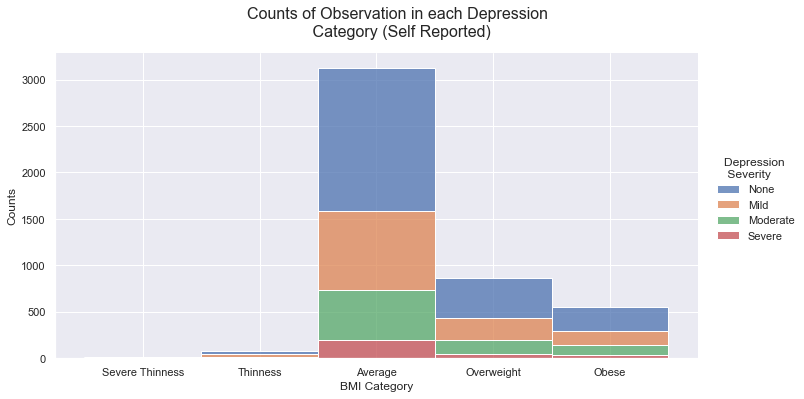

In [66]:
fig = sns.displot(w2_variables, x = "bmi_scale", hue = "severity", aspect = 2, multiple = "stack", legend=True)
fig.legend.set_title("Depression \n Severity")
fig.fig.suptitle('Counts of Observation in each Depression \n Category (Self Reported)',\
                 y = 1.1, size = 16)
plt.xlabel('BMI Category')
plt.ylabel('Counts')
plt.show(fig)

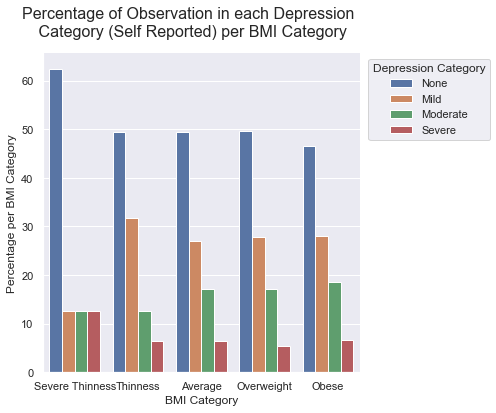

In [67]:
fig = sns.catplot(x = 'bmi_scale', y = 'percentile_per_scale', hue = 'severity', \
                  kind = 'bar', data = w2_counts, legend_out= False)
plt.legend(title = 'Depression Category',bbox_to_anchor=(1.01, 1), loc='upper left')
fig.fig.suptitle('Percentage of Observation in each Depression \n Category (Self Reported) per BMI Category',\
                 y = 1.1, size = 16)
plt.xlabel('BMI Category')
plt.ylabel('Percentage per BMI Category')
plt.show(fig)

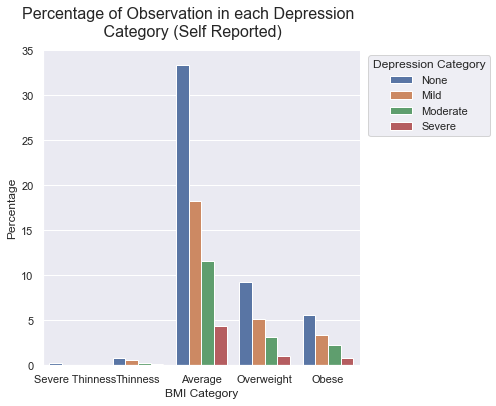

In [68]:
fig = sns.catplot(x = 'bmi_scale', y = 'percentile', hue = 'severity', \
                  kind = 'bar', data = w2_counts, legend_out= False)
plt.legend(title = 'Depression Category',bbox_to_anchor=(1.01, 1), loc='upper left')
fig.fig.suptitle('Percentage of Observation in each Depression \n Category (Self Reported)', y = 1.08, size = 16)
plt.xlabel('BMI Category')
plt.ylabel('Percentage')
plt.show(fig)

In [69]:
w2_counts['depression'] = ['Yes' if (j['severity'] == 'Moderate') or (j['severity'] == 'Severe') \
                           else 'No' for i,j in w2_counts.iterrows()]
w2_counts_bin = w2_counts[['bmi_scale', 'depression', 'counts']]
w2_counts_bin = w2_counts_bin.groupby(['bmi_scale', 'depression'], as_index = False).sum()
w2_counts_bin = w2_counts_bin.merge(w2_counts_per_scale, on = 'bmi_scale', how = 'left')
w2_counts_bin['counts_y'] = (w2_counts_bin['counts_x']/w2_counts_bin['counts_y'])*100
w2_counts_bin = w2_counts_bin.rename(columns = {'counts_x':'counts','counts_y':'percentile_per_scale'})
w2_counts_bin['percentile'] = (w2_counts_bin['counts']/w2_variables.shape[0]) * 100

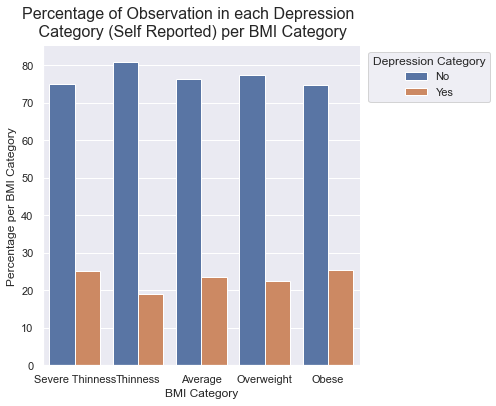

In [70]:
fig = sns.catplot(x = 'bmi_scale', y = 'percentile_per_scale', hue = 'depression', \
                  kind = 'bar', data = w2_counts_bin, legend_out= False)
plt.legend(title = 'Depression Category',bbox_to_anchor=(1.01, 1), loc='upper left')
fig.fig.suptitle('Percentage of Observation in each Depression \n Category (Self Reported) per BMI Category', y = 1.08, size = 16)
plt.xlabel('BMI Category')
plt.ylabel('Percentage per BMI Category')
plt.show(fig)

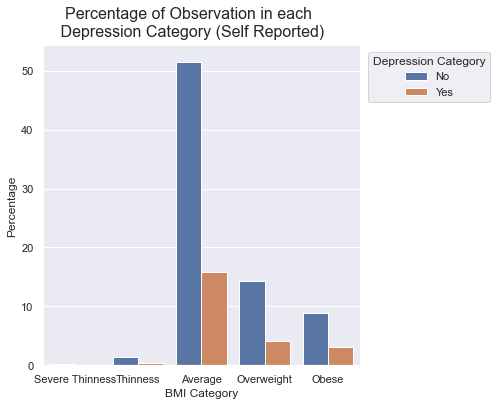

In [71]:
fig = sns.catplot(x = 'bmi_scale', y = 'percentile', hue = 'depression', \
                  kind = 'bar', data = w2_counts_bin, legend_out= False)
plt.legend(title = 'Depression Category',bbox_to_anchor=(1.01, 1), loc='upper left')
fig.fig.suptitle('Percentage of Observation in each \n Depression Category (Self Reported)', y = 1.08, size = 16)
plt.xlabel('BMI Category')
plt.ylabel('Percentage')
plt.show(fig)

## Wave III

In [72]:
w3_variables = wave3[['AID', 'H3ID15', 'H3HGT_F', 'H3HGT_I', 'H3HGT_PI', 'H3WGT', 'H3DA43F', 'H3DA43I', 'H3DA44', 'BIO_SEX3']]
w3_variables = w3_variables.replace({'H3ID15' : {8:0, 9:0},
                                     'H3HGT_F' : {'96':np.nan, '98':np.nan, ' ':np.nan},
                                     'H3HGT_I' : {'96':np.nan, '98':np.nan, ' ':np.nan},
                                     'H3HGT_PI' : {'6':np.nan, '8':np.nan, ' ':np.nan},
                                     'H3WGT' : {'996':np.nan, ' ':np.nan, '6': np.nan, '888': np.nan},
                                     'H3DA43F' : {'96':np.nan, '98':np.nan, ' ':np.nan},
                                     'H3DA43I' : {'96':np.nan, '98':np.nan, ' ':np.nan},
                                     'H3DA44' : {'996':np.nan, '998':np.nan, '999':np.nan, ' ':np.nan},})

cols = w3_variables.columns
w3_variables[cols] = w3_variables[cols].apply(pd.to_numeric, errors='coerce')

w3_variables['height_cm'] = (w3_variables['H3HGT_F'] * 12 + w3_variables['H3HGT_I'] + w3_variables['H3HGT_PI']) * 2.54
w3_variables['weight_kg'] = w3_variables['H3WGT'] * 0.453592
w3_variables['self_height_cm'] = (w3_variables['H3DA43F'] * 12 + w3_variables['H3DA43I']) * 2.54
w3_variables['self_weight_kg'] = w3_variables['H3DA44'] * 0.453592


for i,j in w3_variables.iterrows():
    if(pd.isnull(j['height_cm'])):
        w3_variables.loc[i,'height_cm'] = j['self_height_cm']
    if(pd.isnull(j['weight_kg'])):
        w3_variables.loc[i,'weight_kg'] = j['self_weight_kg']

for i,j in w3_variables.iterrows():
    if(pd.isnull(j['self_height_cm'])):
        w3_variables.loc[i,'self_height_cm'] = j['height_cm']
    if(pd.isnull(j['self_weight_kg'])):
        w3_variables.loc[i,'self_weight_kg'] = j['weight_kg']

w3_variables = w3_variables.dropna()

w3_variables['bmi'] = w3_variables['weight_kg'] / ((w3_variables['height_cm'] / 100) ** 2)
w3_variables['bmi_self_reported'] = w3_variables['self_weight_kg'] / ((w3_variables['self_height_cm'] / 100) ** 2)

bmi_cat = ['Severely Underweight','Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III']
bmi_bins = [0, 16.4, 18.4, 24.9, 29.9, 34.9, 39.9, 100]
w3_variables['bmi_scale'] = pd.cut(w3_variables['bmi'], bins=bmi_bins, labels=bmi_cat)  
        
w3_variables = w3_variables[['AID', 'H3ID15', 'bmi', 'bmi_scale', 'bmi_self_reported', 'BIO_SEX3']]
w3_variables = w3_variables.rename(columns = {'H3ID15': 'doc_depression', 'BIO_SEX3':'gender'})

In [73]:
aid_w3 = wave3.loc[:,'AID']
w3_depression_index_ces_raw = wave3[['H3SP5','H3SP8','H3SP9','H3SP10','H3SP3', #satisfied with life
                                    'H3SP2', #cried
                                    'H3SP12', #sad
                                    'H3SP11', #enjoyed life
                                    'H3SP13', #disliked you
                                    'H3GH15']] #sleep
w3_depression_index_ces_raw = pd.concat([aid_w3,w3_depression_index_ces_raw], axis = 1)

In [74]:
#Replacing all unknown values as 'not a number'
w3_depression_index_ces_raw = w3_depression_index_ces_raw.replace([6,8,9], np.nan)

#Reversing all questions that are positive
w3_depression_index_ces_raw['H3SP11'] = 3 - w3_depression_index_ces_raw['H3SP11']

#Scaling questions with five response options into four (as per CES-D scale)
w3_depression_index_ces_raw['H3SP2'] = w3_depression_index_ces_raw['H3SP2'].replace({1: 0 , 2: 1, 3: 2, 4: 3})
w3_depression_index_ces_raw['H3SP3'] = w3_depression_index_ces_raw['H3SP3'].replace({1: 0 , 2: 0, 3: 1, 4: 2, 5: 3})


In [75]:
w3_depression_index_ces = pd.DataFrame()

w3_depression_index_ces['AID'] = w3_depression_index_ces_raw['AID']
w3_depression_index_ces['q1'] = w3_depression_index_ces_raw['H3SP5']
w3_depression_index_ces['q2'] = w3_depression_index_ces_raw['H3SP8']
w3_depression_index_ces['q3'] = w3_depression_index_ces_raw['H3SP9']
w3_depression_index_ces['q4'] = w3_depression_index_ces_raw['H3SP10']

#following questions do not exactly follow through with CES-D 10 questionnaire
w3_depression_index_ces['q5'] = w3_depression_index_ces_raw['H3SP3']
w3_depression_index_ces['q6'] = w3_depression_index_ces_raw['H3SP2']
w3_depression_index_ces['q7'] = w3_depression_index_ces_raw['H3SP12']
w3_depression_index_ces['q8'] = w3_depression_index_ces_raw['H3SP11']
w3_depression_index_ces['q9'] = w3_depression_index_ces_raw['H3SP13']
w3_depression_index_ces['q10'] = w3_depression_index_ces_raw['H3GH15']

w3_depression_index_ces['null_count'] = w3_depression_index_ces.isnull().sum(axis=1)

w3_depression_index_ces['score'] = [(j[1:11].sum() * 10)/j[1:11].count() if j['null_count'] < 3 
                             else np.nan
                             for i,j in w3_depression_index_ces.iterrows()]
w3_depression_index_ces[w3_depression_index_ces['null_count'] > 0]

dep_severity = ['No', 'Yes']
bin_cuts = [-1, 10, 30]
w3_depression_index_ces['depression'] = pd.cut(w3_depression_index_ces['score'], bins=bin_cuts, labels=dep_severity)

w3_depression_index_ces = w3_depression_index_ces.dropna(subset=['score'])

w3_depression_ces = w3_depression_index_ces[['AID', 'score', 'depression']]

w3_variables = w3_variables.merge(w3_depression_ces, on = 'AID', how = 'inner')

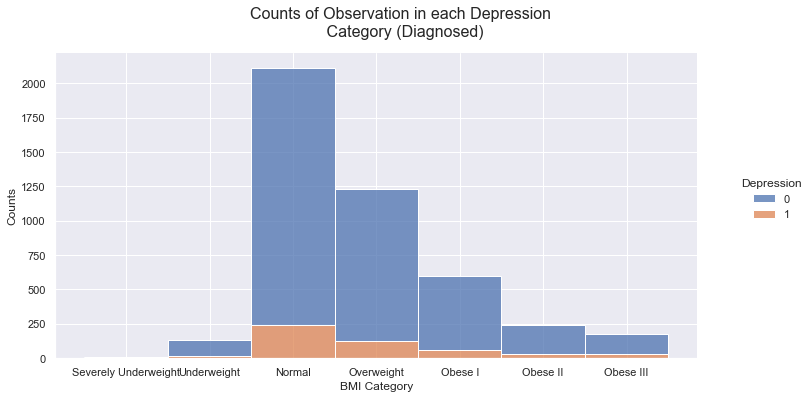

In [76]:
fig = sns.displot(w3_variables, x = "bmi_scale", hue = "doc_depression", legend = True, aspect = 2, multiple = "stack")
fig.legend.set_title("Depression")
fig.fig.suptitle('Counts of Observation in each Depression \n Category (Diagnosed)',\
                 y = 1.1, size = 16)
plt.xlabel('BMI Category')
plt.ylabel('Counts')
plt.show(fig)

In [77]:
w3_variables = w3_variables.replace({'doc_depression' : {0:'No', 1:'Yes'}})
w3_counts = w3_variables.groupby(['bmi_scale', 'doc_depression'], \
                                 as_index = False).count()[['bmi_scale', 'doc_depression', 'AID']]
w3_counts = w3_counts.rename(columns = {"AID" : "counts"})
w3_counts_per_scale = w3_counts.groupby(['bmi_scale'], as_index = False).sum()
w3_counts = w3_counts.merge(w3_counts_per_scale, on = 'bmi_scale', how = 'left')
w3_counts['counts_y'] = (w3_counts['counts_x']/w3_counts['counts_y'])*100
w3_counts = w3_counts.rename(columns = {'counts_x':'counts','counts_y':'percentile_per_scale'})
w3_counts['percentile'] = (w3_counts['counts']/w3_variables.shape[0]) * 100

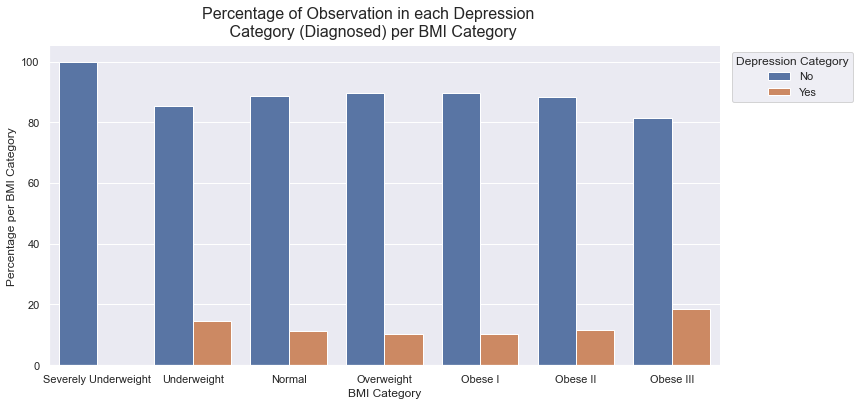

In [78]:
fig = sns.catplot(x = 'bmi_scale', y = 'percentile_per_scale', hue = 'doc_depression', \
                  kind = 'bar', data = w3_counts, legend_out= False, aspect = 2)
plt.legend(title = 'Depression Category',bbox_to_anchor=(1.01, 1), loc='upper left')
plt.suptitle('Percentage of Observation in each Depression \n Category (Diagnosed) per BMI Category', y = 1.08, size = 16)
plt.xlabel('BMI Category')
plt.ylabel('Percentage per BMI Category')
plt.show(fig)

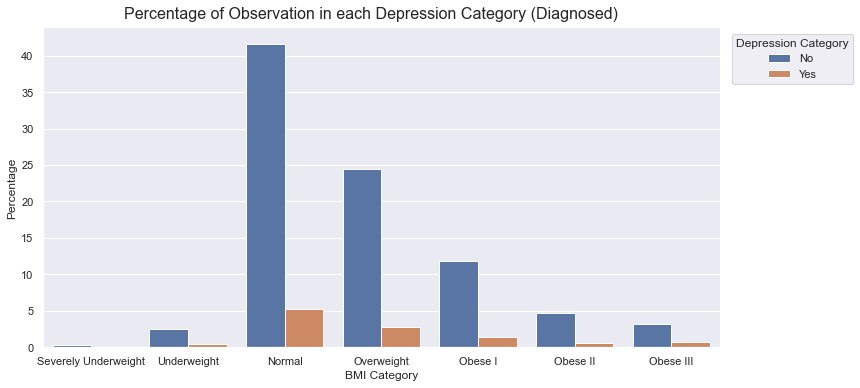

In [79]:
fig = sns.catplot(x = 'bmi_scale', y = 'percentile', hue = 'doc_depression', \
                  kind = 'bar', data = w3_counts, legend_out= False, aspect = 2)
plt.legend(title = 'Depression Category',bbox_to_anchor=(1.01, 1), loc='upper left')
fig.fig.suptitle('Percentage of Observation in each Depression Category (Diagnosed)', y = 1.03, size = 16)
plt.xlabel('BMI Category')
plt.ylabel('Percentage')
plt.show(fig)

## Wave IV

In [80]:
w4_variables = wave4[['AID','H4BMI','H4BMICLS', 'H4ID5H', 'BIO_SEX4', 'H4GH6', 'H4GH5F','H4GH5I']]
w4_variables = w4_variables.replace({'H4BMICLS' : {1 : 'Underweight', \
                                                   2 : 'Normal', \
                                                   3 : 'Overweight', \
                                                   4 : 'Obese I', \
                                                   5 : 'Obese II', \
                                                   6 : 'Obese III', \
                                                   88 : np.nan, \
                                                   89 : np.nan, \
                                                   96 : np.nan, \
                                                   97 : np.nan, \
                                                   99 : np.nan},
                                     'H4ID5H' : {6: 0},
                                     'H4HGT' : {996: np.nan, \
                                                997: np.nan, \
                                                999: np.nan},
                                     'H4WGT' : {888: 201,
                                                889: np.nan,
                                                996: np.nan, \
                                                997: np.nan, \
                                                999: np.nan}})

w4_variables = w4_variables.rename(columns={"H4BMI": "bmi", "H4BMICLS": "bmi_scale", "BIO_SEX4": "gender", \
                                            'H4ID5H':'doc_depression'})         
w4_variables = w4_variables.merge(wave4_inflammatory[['AID', 'C_INFECT']], on = 'AID')
w4_variables = w4_variables.dropna()

w4_variables['bmi_self_reported'] = w4_variables['H4GH6'] * 0.453592 / \
((((w4_variables['H4GH5F'] * 12 + w4_variables['H4GH5I']) * 2.54) / 100) ** 2)

cat_type = CategoricalDtype(categories = ["Underweight", "Normal", "Overweight", "Obese I", "Obese II", "Obese III"], ordered = True)

w4_variables = w4_variables[['AID', 'bmi', 'bmi_scale', 'bmi_self_reported', 'gender', 'doc_depression', 'C_INFECT']]
w4_variables['bmi_scale'] = w4_variables['bmi_scale'].astype(cat_type)

In [81]:
aid_w4 = wave4.loc[:,'AID']
w4_depression_index_ces_raw = wave4[['H4MH18','H4MH21','H4MH22','H4MH23','H4MH24', #happy
                       'H4MH2', #lonely
                       'H4MH26', #sad
                       'H4MH25', #enjoyed life
                       'H4MH27', #disliked you
                       'H4SP6']] #sleep
w4_depression_index_ces_raw = pd.concat([aid_w4,w4_depression_index_ces_raw], axis = 1)

In [82]:
#Replacing all unknown values as 'not a number'
w4_depression_index_ces_raw = w4_depression_index_ces_raw.replace([6,8,9], np.nan)

#Reversing all questions that are positive
w4_depression_index_ces_raw['H4MH24'] = 3 - w4_depression_index_ces_raw['H4MH24']
w4_depression_index_ces_raw['H4MH25'] = 3 - w4_depression_index_ces_raw['H4MH25']

#Scaling questions with five response options into four (as per CES-D scale)
w4_depression_index_ces_raw['H4SP6'] = w4_depression_index_ces_raw['H4SP6'].replace({1: 0 , 2: 0, 3: 1, 4: 2, 5: 3})


In [83]:
w4_depression_index_ces = pd.DataFrame()

w4_depression_index_ces['AID'] = w4_depression_index_ces_raw['AID']
w4_depression_index_ces['q1'] = w4_depression_index_ces_raw['H4MH18']
w4_depression_index_ces['q2'] = w4_depression_index_ces_raw['H4MH21']
w4_depression_index_ces['q3'] = w4_depression_index_ces_raw['H4MH22']
w4_depression_index_ces['q4'] = w4_depression_index_ces_raw['H4MH23']
w4_depression_index_ces['q6'] = w4_depression_index_ces_raw['H4MH2']
w4_depression_index_ces['q7'] = w4_depression_index_ces_raw['H4SP6']
w4_depression_index_ces['q8'] = w4_depression_index_ces_raw['H4MH24']

#following questions do not exactly follow through with CES-D 10 questionnaire
w4_depression_index_ces['q5'] = w4_depression_index_ces_raw['H4MH26']
w4_depression_index_ces['q9'] = w4_depression_index_ces_raw['H4MH25']
w4_depression_index_ces['q10'] = w4_depression_index_ces_raw['H4MH27']

w4_depression_index_ces['null_count'] = w4_depression_index_ces.isnull().sum(axis=1)

w4_depression_index_ces['score'] = [(j[1:11].sum() * 10)/j[1:11].count() if j['null_count'] < 3 
                             else np.nan
                             for i,j in w4_depression_index_ces.iterrows()]
w4_depression_index_ces[w4_depression_index_ces['null_count'] > 0]

dep_severity = ['No', 'Yes']
bin_cuts = [-1, 10, 30]
w4_depression_index_ces['depression'] = pd.cut(w4_depression_index_ces['score'], bins=bin_cuts, labels=dep_severity)

w4_depression_index_ces = w4_depression_index_ces.dropna(subset=['score'])

w4_depression_ces = w4_depression_index_ces[['AID', 'score', 'depression']]

w4_variables = w4_variables.merge(w4_depression_ces, on = 'AID', how = 'inner')

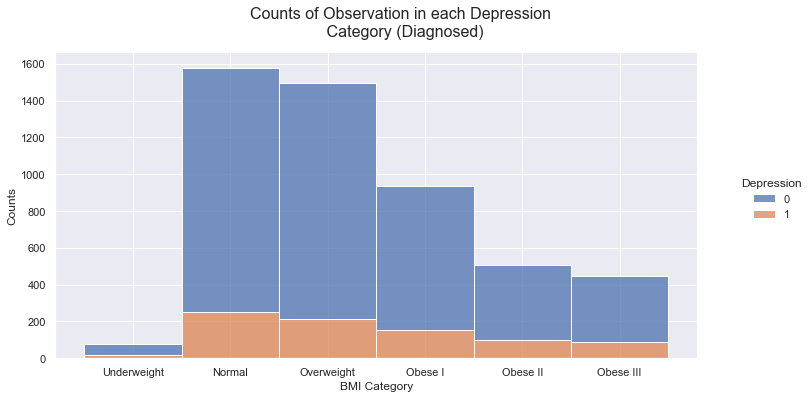

In [84]:
fig = sns.displot(w4_variables, x = "bmi_scale", hue = "doc_depression", legend = True, aspect = 2, multiple = "stack")
fig.legend.set_title("Depression")
fig.fig.suptitle('Counts of Observation in each Depression \n Category (Diagnosed)',\
                 y = 1.1, size = 16)
plt.xlabel('BMI Category')
plt.ylabel('Counts')
plt.show(fig)

In [85]:
w4_variables = w4_variables.replace({'doc_depression' : {0:'No', 1:'Yes'}})
w4_counts = w4_variables.groupby(['bmi_scale', 'doc_depression'], \
                                 as_index = False).count()[['bmi_scale', 'doc_depression', 'AID']]
w4_counts = w4_counts.rename(columns = {"AID" : "counts"})
w4_counts_per_scale = w4_counts.groupby(['bmi_scale'], as_index = False).sum()
w4_counts = w4_counts.merge(w4_counts_per_scale, on = 'bmi_scale', how = 'left')
w4_counts['counts_y'] = (w4_counts['counts_x']/w4_counts['counts_y'])*100
w4_counts = w4_counts.rename(columns = {'counts_x':'counts','counts_y':'percentile_per_scale'})
w4_counts['percentile'] = (w4_counts['counts']/w4_variables.shape[0]) * 100

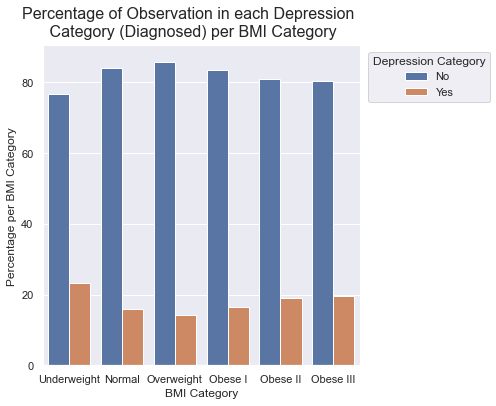

In [86]:
fig = sns.catplot(x = 'bmi_scale', y = 'percentile_per_scale', hue = 'doc_depression', \
                  kind = 'bar', data = w4_counts, legend_out= False)
plt.legend(title = 'Depression Category',bbox_to_anchor=(1.01, 1), loc='upper left')
fig.fig.suptitle('Percentage of Observation in each Depression \n Category (Diagnosed) per BMI Category', y = 1.08, size = 16)
plt.xlabel('BMI Category')
plt.ylabel('Percentage per BMI Category')
plt.show(fig)

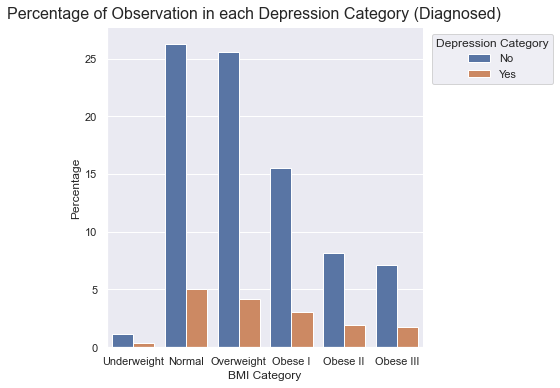

In [87]:
fig = sns.catplot(x = 'bmi_scale', y = 'percentile', hue = 'doc_depression', \
                  kind = 'bar', data = w4_counts, legend_out= False)
plt.legend(title = 'Depression Category',bbox_to_anchor=(1.01, 1), loc='upper left')
fig.fig.suptitle('Percentage of Observation in each Depression Category (Diagnosed)', y = 1.03, size = 16)
plt.xlabel('BMI Category')
plt.ylabel('Percentage')
plt.show(fig)

# Longitudinal Analysis (Cross-Wave Analysis)

People who are both diagnosed with depressive symptoms in both periods, there are 444 observations who have depressive symptoms in both waves, and appears to be good enough to regress.

In [88]:
w1_w2 = w2_variables[['AID','score']].rename(columns = {'score':'score_w2'}).merge(regression, how = 'inner', on = 'AID')
len(w1_w2[(w1_w2['score_w2'] >= 16) & (w1_w2['score'] >= 16)])

444

In [89]:
w1_w2['depressed_w1_w2'] = [1 if (j['score_w2'] >= 16) & (j['score'] >= 16) else 0 for i,j in w1_w2.iterrows()]
w1_w2['score_w1_w2'] = (w1_w2['score'] + w1_w2['score_w2'])/2

dep_severity = ['None', 'Mild', 'Moderate', 'Severe']
bin_cuts = [-1, 9, 15, 24, 60]
w1_w2['severity_w1_w2'] = pd.cut(w1_w2['score_w1_w2'], bins=bin_cuts, labels=dep_severity)

## Wave 1&2 to Wave 3

In [90]:
w3_longitudinal = w3_variables.rename(columns={'bmi':'bmi_w3', \
                             'bmi_scale':'bmi_scale_w3', \
                             'bmi_self_reported':'bmi_self_reported_w3', \
                             'score':'score_w3', \
                             'doc_depression':'doc_depression_w3', \
                             'depression':'depression_w3'}).drop(['gender'], \
                                                                 axis = 1).merge(w1_w2, \
                                                                                 on = 'AID', how = 'left').dropna()

w3_longitudinal = wave3_weights.drop(['CLUSTER2','GSWGT3'], \
                                         axis = 1).merge(w3_longitudinal, \
                                                          on = 'AID').rename(columns = {'GSWGT3_2':'w3_weight'})

### BMI as Dependent Variable
#### Using Measured BMI

In [148]:
formula = 'bmi_w3 ~ score_w1_w2*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w3 = smf.wls(formula = formula, data = w3_longitudinal, \
                    freq_weights=np.asarray(w3_longitudinal['w3_weight'])).fit()
print(ols_w12_w3.summary())

                            WLS Regression Results                            
Dep. Variable:                 bmi_w3   R-squared:                       0.044
Model:                            WLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     4.141
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           1.06e-12
Time:                        07:35:03   Log-Likelihood:                -8264.1
No. Observations:                2635   AIC:                         1.659e+04
Df Residuals:                    2605   BIC:                         1.676e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [92]:
formula = 'bmi_w3 ~ C(severity_w1_w2)*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w3_2 = smf.wls(formula = formula, data = w3_longitudinal, \
                    freq_weights=np.asarray(w3_longitudinal['w3_weight'])).fit()
print(ols_w12_w3_2.summary())

                            WLS Regression Results                            
Dep. Variable:                 bmi_w3   R-squared:                       0.046
Model:                            WLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     3.812
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           2.15e-12
Time:                        05:10:27   Log-Likelihood:                -8261.2
No. Observations:                2635   AIC:                         1.659e+04
Df Residuals:                    2601   BIC:                         1.679e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [93]:
formula = 'bmi_w3 ~ C(depressed_w1_w2)*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w3_3 = smf.wls(formula = formula, data = w3_longitudinal, \
                    freq_weights=np.asarray(w3_longitudinal['w3_weight'])).fit()
print(ols_w12_w3_3.summary())

                            WLS Regression Results                            
Dep. Variable:                 bmi_w3   R-squared:                       0.039
Model:                            WLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     3.614
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           2.91e-10
Time:                        05:10:27   Log-Likelihood:                -8271.5
No. Observations:                2635   AIC:                         1.660e+04
Df Residuals:                    2605   BIC:                         1.678e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

#### Using Self-Reported BMI

In [153]:
formula = 'bmi_self_reported_w3 ~ score_w1_w2*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w3_4 = smf.wls(formula = formula, data = w3_longitudinal, \
                    freq_weights=np.asarray(w3_longitudinal['w3_weight'])).fit()
print(ols_w12_w3_4.summary())

                             WLS Regression Results                             
Dep. Variable:     bmi_self_reported_w3   R-squared:                       0.051
Model:                              WLS   Adj. R-squared:                  0.040
Method:                   Least Squares   F-statistic:                     4.804
Date:                  Mon, 21 Dec 2020   Prob (F-statistic):           7.32e-16
Time:                          07:48:13   Log-Likelihood:                -8052.6
No. Observations:                  2635   AIC:                         1.617e+04
Df Residuals:                      2605   BIC:                         1.634e+04
Df Model:                            29                                         
Covariance Type:              nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [155]:
formula = 'bmi_self_reported_w3 ~ C(severity_w1_w2)*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w3_5 = smf.wls(formula = formula, data = w3_longitudinal, \
                    freq_weights=np.asarray(w3_longitudinal['w3_weight'])).fit()
print(ols_w12_w3_5.summary())

                             WLS Regression Results                             
Dep. Variable:     bmi_self_reported_w3   R-squared:                       0.052
Model:                              WLS   Adj. R-squared:                  0.040
Method:                   Least Squares   F-statistic:                     4.338
Date:                  Mon, 21 Dec 2020   Prob (F-statistic):           3.61e-15
Time:                          07:49:04   Log-Likelihood:                -8050.6
No. Observations:                  2635   AIC:                         1.617e+04
Df Residuals:                      2601   BIC:                         1.637e+04
Df Model:                            33                                         
Covariance Type:              nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [96]:
formula = 'bmi_self_reported_w3 ~ C(depressed_w1_w2) + C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w3_6 = smf.wls(formula = formula, data = w3_longitudinal, \
                    freq_weights=np.asarray(w3_longitudinal['w3_weight'])).fit()
print(ols_w12_w3_6.summary())

                             WLS Regression Results                             
Dep. Variable:     bmi_self_reported_w3   R-squared:                       0.044
Model:                              WLS   Adj. R-squared:                  0.033
Method:                   Least Squares   F-statistic:                     4.252
Date:                  Mon, 21 Dec 2020   Prob (F-statistic):           7.61e-13
Time:                          05:10:27   Log-Likelihood:                -8062.4
No. Observations:                  2635   AIC:                         1.618e+04
Df Residuals:                      2606   BIC:                         1.635e+04
Df Model:                            28                                         
Covariance Type:              nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

### Depression Score as Dependent Variable

In [97]:
formula = 'score_w3 ~ bmi_adjusted*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w3_7 = smf.wls(formula = formula, data = w3_longitudinal, \
                    freq_weights=np.asarray(w3_longitudinal['w3_weight'])).fit()
print(ols_w12_w3_7.summary())

                            WLS Regression Results                            
Dep. Variable:               score_w3   R-squared:                       0.095
Model:                            WLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     9.379
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           5.71e-39
Time:                        05:10:27   Log-Likelihood:                -7036.4
No. Observations:                2635   AIC:                         1.413e+04
Df Residuals:                    2605   BIC:                         1.431e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [98]:
formula = 'score_w3 ~ C(bmi_scale)*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w3_8 = smf.wls(formula = formula, data = w3_longitudinal, \
                    freq_weights=np.asarray(w3_longitudinal['w3_weight'])).fit()
print(ols_w12_w3_8.summary())

                            WLS Regression Results                            
Dep. Variable:               score_w3   R-squared:                       0.095
Model:                            WLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     7.780
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           2.74e-36
Time:                        05:10:27   Log-Likelihood:                -7035.9
No. Observations:                2635   AIC:                         1.414e+04
Df Residuals:                    2599   BIC:                         1.436e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

## Wave 1&2 to Wave 4

In [99]:
w4_longitudinal = w4_variables.rename(columns={'bmi':'bim_w4', \
                             'bmi_scale':'bmi_scale_w4', \
                             'bmi_self_reported':'bmi_self_reported_w4', \
                             'score':'score_w4', \
                             'doc_depression':'doc_depression_w4', \
                             'depression':'depression_w4'}).drop(['gender'], \
                                                                 axis = 1).merge(w1_w2, \
                                                                                 on = 'AID', how = 'left').dropna()

w4_longitudinal = wave4_weights.drop(['CLUSTER2','GSWGT4','GSWGT134'], \
                                         axis = 1).merge(w4_longitudinal, \
                                                          on = 'AID').rename(columns = {'GSWGT4_2':'w4_weight'})

### BMI as Dependent Variable
#### Using Measured BMI

In [100]:
formula = 'bim_w4 ~ score_w1_w2*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w4 = smf.wls(formula = formula, data = w4_longitudinal, \
                    freq_weights=np.asarray(w4_longitudinal['w4_weight'])).fit()
print(ols_w12_w4.summary())

                            WLS Regression Results                            
Dep. Variable:                 bim_w4   R-squared:                       0.044
Model:                            WLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     4.466
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           2.84e-14
Time:                        05:10:27   Log-Likelihood:                -9679.2
No. Observations:                2869   AIC:                         1.942e+04
Df Residuals:                    2839   BIC:                         1.960e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [101]:
formula = 'bim_w4 ~ C(severity_w1_w2)*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w4_2 = smf.wls(formula = formula, data = w4_longitudinal, \
                    freq_weights=np.asarray(w4_longitudinal['w4_weight'])).fit()
print(ols_w12_w4_2.summary())

                            WLS Regression Results                            
Dep. Variable:                 bim_w4   R-squared:                       0.045
Model:                            WLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     4.052
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           1.11e-13
Time:                        05:10:28   Log-Likelihood:                -9677.1
No. Observations:                2869   AIC:                         1.942e+04
Df Residuals:                    2835   BIC:                         1.962e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [102]:
formula = 'bim_w4 ~ C(depressed_w1_w2)*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w4_3 = smf.wls(formula = formula, data = w4_longitudinal, \
                    freq_weights=np.asarray(w4_longitudinal['w4_weight'])).fit()
print(ols_w12_w4_3.summary())

                            WLS Regression Results                            
Dep. Variable:                 bim_w4   R-squared:                       0.042
Model:                            WLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     4.299
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           1.79e-13
Time:                        05:10:28   Log-Likelihood:                -9681.6
No. Observations:                2869   AIC:                         1.942e+04
Df Residuals:                    2839   BIC:                         1.960e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

#### Using Self-Reported BMI

In [168]:
formula = 'bmi_self_reported_w4 ~ score_w1_w2*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w4_4 = smf.wls(formula = formula, data = w4_longitudinal, \
                    freq_weights=np.asarray(w4_longitudinal['w4_weight'])).fit()
print(ols_w12_w4_4.summary())

                             WLS Regression Results                             
Dep. Variable:     bmi_self_reported_w4   R-squared:                       0.016
Model:                              WLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     1.641
Date:                  Mon, 21 Dec 2020   Prob (F-statistic):             0.0169
Time:                          08:17:13   Log-Likelihood:                -12256.
No. Observations:                  2869   AIC:                         2.457e+04
Df Residuals:                      2839   BIC:                         2.475e+04
Df Model:                            29                                         
Covariance Type:              nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [166]:
formula = 'bmi_self_reported_w4 ~ C(severity_w1_w2)*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w4_5 = smf.wls(formula = formula, data = w4_longitudinal, \
                    freq_weights=np.asarray(w4_longitudinal['w4_weight'])).fit()
print(ols_w12_w4_5.summary())

                             WLS Regression Results                             
Dep. Variable:     bmi_self_reported_w4   R-squared:                       0.016
Model:                              WLS   Adj. R-squared:                  0.005
Method:                   Least Squares   F-statistic:                     1.416
Date:                  Mon, 21 Dec 2020   Prob (F-statistic):             0.0587
Time:                          08:16:51   Log-Likelihood:                -12257.
No. Observations:                  2869   AIC:                         2.458e+04
Df Residuals:                      2835   BIC:                         2.478e+04
Df Model:                            33                                         
Covariance Type:              nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [169]:
formula = 'bmi_self_reported_w4 ~ C(depressed_w1_w2)*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w4_6 = smf.wls(formula = formula, data = w4_longitudinal, \
                    freq_weights=np.asarray(w4_longitudinal['w4_weight'])).fit()
print(ols_w12_w4_6.summary())

                             WLS Regression Results                             
Dep. Variable:     bmi_self_reported_w4   R-squared:                       0.016
Model:                              WLS   Adj. R-squared:                  0.005
Method:                   Least Squares   F-statistic:                     1.545
Date:                  Mon, 21 Dec 2020   Prob (F-statistic):             0.0317
Time:                          08:17:42   Log-Likelihood:                -12258.
No. Observations:                  2869   AIC:                         2.458e+04
Df Residuals:                      2839   BIC:                         2.475e+04
Df Model:                            29                                         
Covariance Type:              nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

### Depression Score as Dependent Variable

In [106]:
formula = 'score_w4 ~ bmi_adjusted*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w4_7 = smf.wls(formula = formula, data = w4_longitudinal, \
                    freq_weights=np.asarray(w4_longitudinal['w4_weight'])).fit()
print(ols_w12_w4_7.summary())

                            WLS Regression Results                            
Dep. Variable:               score_w4   R-squared:                       0.090
Model:                            WLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     9.665
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           1.24e-40
Time:                        05:10:28   Log-Likelihood:                -8226.3
No. Observations:                2869   AIC:                         1.651e+04
Df Residuals:                    2839   BIC:                         1.669e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [107]:
formula = 'score_w4 ~ C(bmi_scale)*C(gender) + age + parent_income + C(self_esteem) + C(exercise) + C(checkup) + \
C(veg_fruit) + C(parental_support) + C(friendship) + C(race)'
ols_w12_w4_8 = smf.wls(formula = formula, data = w4_longitudinal, \
                    freq_weights=np.asarray(w4_longitudinal['w4_weight'])).fit()
print(ols_w12_w4_8.summary())

                            WLS Regression Results                            
Dep. Variable:               score_w4   R-squared:                       0.091
Model:                            WLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     8.139
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           1.18e-38
Time:                        05:10:28   Log-Likelihood:                -8224.0
No. Observations:                2869   AIC:                         1.652e+04
Df Residuals:                    2833   BIC:                         1.673e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [108]:
formula = 'bim_w4 ~ score'
ols_dep_bmi_w1_w4 = smf.wls(formula = formula, data = w4_longitudinal, \
                    freq_weights=np.asarray(w4_longitudinal['w4_weight'])).fit()
print(ols_dep_bmi_w1_w4.summary())

                            WLS Regression Results                            
Dep. Variable:                 bim_w4   R-squared:                       0.005
Model:                            WLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.28
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           0.000273
Time:                        05:10:28   Log-Likelihood:                -9736.6
No. Observations:                2869   AIC:                         1.948e+04
Df Residuals:                    2867   BIC:                         1.949e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.0148      0.236    118.743      0.0

# Visualisations
## Wave I

<AxesSubplot:xlabel='parent_income', ylabel='Density'>

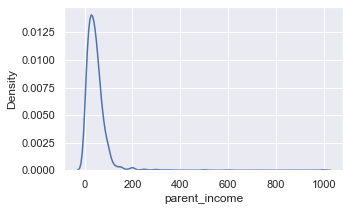

In [111]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 3)

sns.kdeplot(data=confounders['parent_income'], ax = ax)

<AxesSubplot:xlabel='parent_income_bin', ylabel='count'>

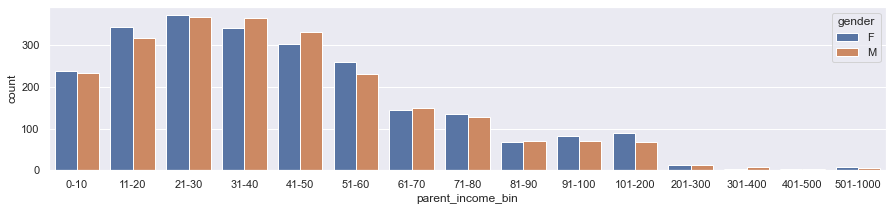

In [112]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 3)

sns.countplot(x="parent_income_bin", hue = "gender", data=regression, ax = ax)

<AxesSubplot:xlabel='score', ylabel='bmi_adjusted'>

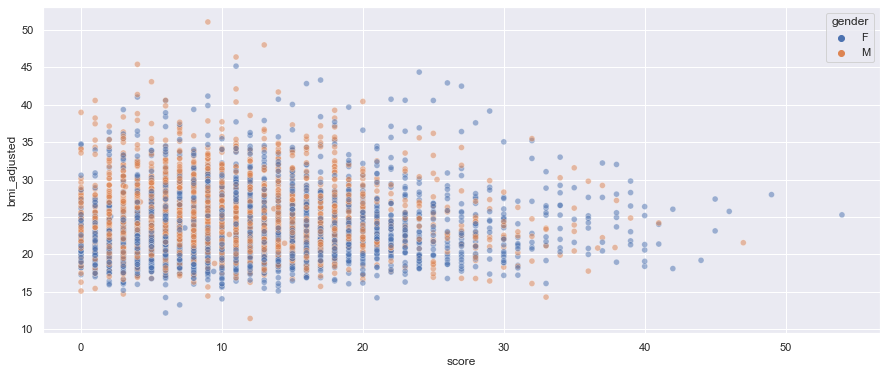

In [113]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)

sns.scatterplot(data=regression, x="score", y="bmi_adjusted", hue="gender", alpha = 0.5)

In [114]:
#sns.catplot(x="bmi_scale", y="score", hue = 'gender', col="parent_income_bin", col_wrap = 3, \
#            data=regression, capsize = 0.1, palette = "Blues_d", kind = "bar")

## All Waves

In [115]:
w2_variables['depression'] = ['Yes' if (j['severity'] == 'Moderate') or (j['severity'] == 'Severe') \
                           else 'No' for i,j in w2_variables.iterrows()]
w2_variables['wave'] = 'wave_2'
w3_variables['wave'] = 'wave_3'
w4_variables['wave'] = 'wave_4'
w2_variables = w2_variables.rename(columns = {'bmi_adjusted': 'bmi'})
w1_variables = bmi_percentile_df.merge(depression_ces, on = 'AID').merge(wave1[['AID', 'BIO_SEX']], on = 'AID')
w1_variables = w1_variables.replace({'BIO_SEX' : {6 : np.nan, 8 : np.nan}})
w1_variables = w1_variables.dropna()
w1_variables['wave'] = 'wave_1'
w1_variables = w1_variables.rename(columns = {'bmi_adjusted': 'bmi', 'BIO_SEX': 'gender'})
w1_variables['depression'] = ['Yes' if (j['severity'] == 'Moderate') or (j['severity'] == 'Severe') \
                           else 'No' for i,j in w1_variables.iterrows()]

all_waves = pd.concat([w1_variables[['bmi', 'depression', 'wave', 'gender']], \
         w2_variables[['bmi', 'depression', 'wave', 'gender']], \
         w3_variables[['bmi', 'depression', 'wave', 'gender']], \
         w4_variables[['bmi', 'depression', 'wave', 'gender']]])

all_waves = all_waves.replace({'gender' : {1 : 'Male', 2 : 'Female'}})

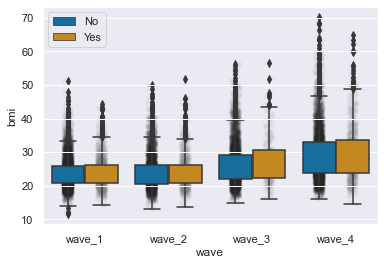

In [116]:
fig = sns.stripplot(y = 'bmi', x = 'wave', data = all_waves, jitter = True, dodge = True, marker = 'o', alpha = 0.05, hue = 'depression', color = 'grey', zorder = 0)
fig = sns.boxplot(y = 'bmi', x = 'wave', data = all_waves, palette = 'colorblind', hue = 'depression', zorder = 0.5)

handles, labels = fig.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])
plt.show(fig)

<AxesSubplot:xlabel='depression', ylabel='bmi'>

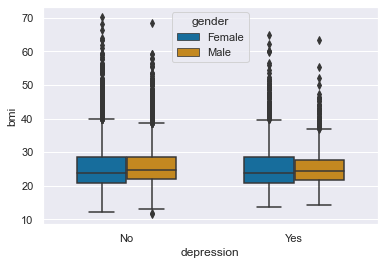

In [117]:
sns.boxplot(y = 'bmi', x = 'depression', data = all_waves, palette = 'colorblind', hue = 'gender', width = 0.6)

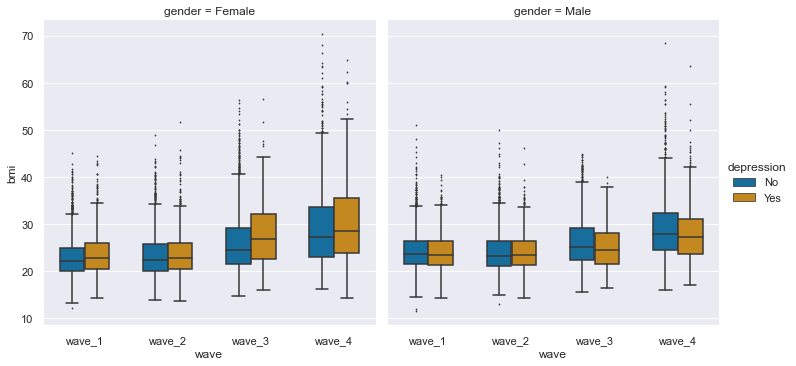

In [118]:
#fig, ax = plt.subplots()
sns.catplot(y = 'bmi', \
            x = 'wave', \
            data = all_waves, \
            palette = 'colorblind', \
            hue = 'depression', \
            width = 0.6, \
            col = 'gender', \
            kind = 'box', \
            fliersize = 0.9)

plt.show()

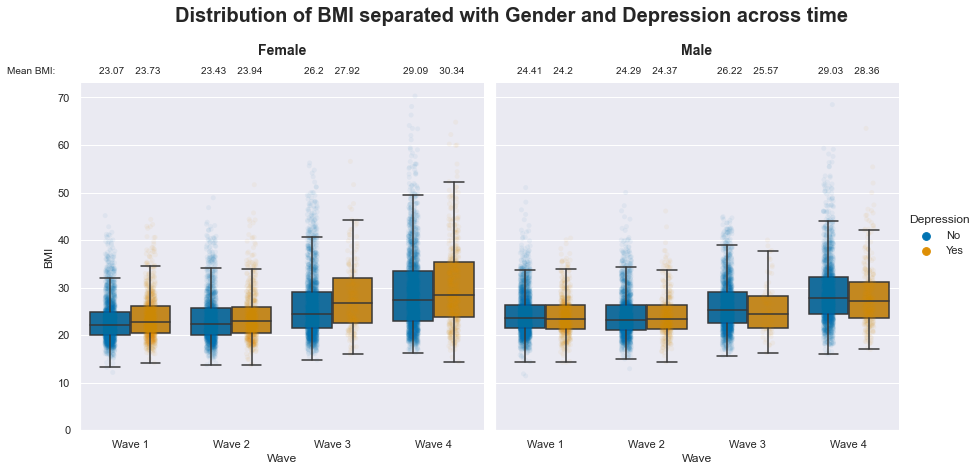

In [172]:
g = sns.FacetGrid(all_waves, col = "gender", height = 6)

flierprops = dict(marker='o', markerfacecolor='grey', markersize=3,
                  linestyle='none', markeredgecolor='grey', alpha = 0.5)

g.fig.suptitle('Distribution of BMI separated with Gender and Depression across time', y = 1.05, fontsize = 20, \
               fontweight = 'demi')

g.map_dataframe(sns.stripplot, x = "wave", y = "bmi", hue = "depression", jitter = True, \
                dodge = True, marker = 'o', alpha = 0.05, palette = 'colorblind', zorder = 1, hue_order = ['No', 'Yes'])
g.map_dataframe(sns.boxplot, x = "wave", y = "bmi", hue = "depression", palette = 'colorblind', \
                showfliers = False, zorder = 2, hue_order = ['No', 'Yes'])

g.set_titles('{col_name}', pad = 28, size = 14, weight = 'demi')
#g.set_axis_labels("Wave", "BMI")
g.set_ylabels("BMI")
g.set_xlabels("Wave")
g.set(ylim=(0, 73))
g.set_xticklabels(['Wave 1', 'Wave 2', 'Wave 3', 'Wave 4'])
g.add_legend(title = "Depression")

mean = all_waves.groupby(['gender','wave','depression'], as_index = False)['bmi'].mean().round(2)
mean = mean.groupby(['gender','wave'])['bmi'].apply(list)
means = []
for i in mean:
    means.append('    '.join(map(str, i)))

vertical_offset = 75
lst = list(np.arange(0,4,0.5))*2
count = 0
for ax in g.axes.flat:
    for i in ax.get_xticks():
        ax.text(i,vertical_offset, means[count], horizontalalignment = 'center')
        count += 1
plt.figtext(-0.04,0.895, 'Mean BMI:', horizontalalignment = 'left')
plt.show()

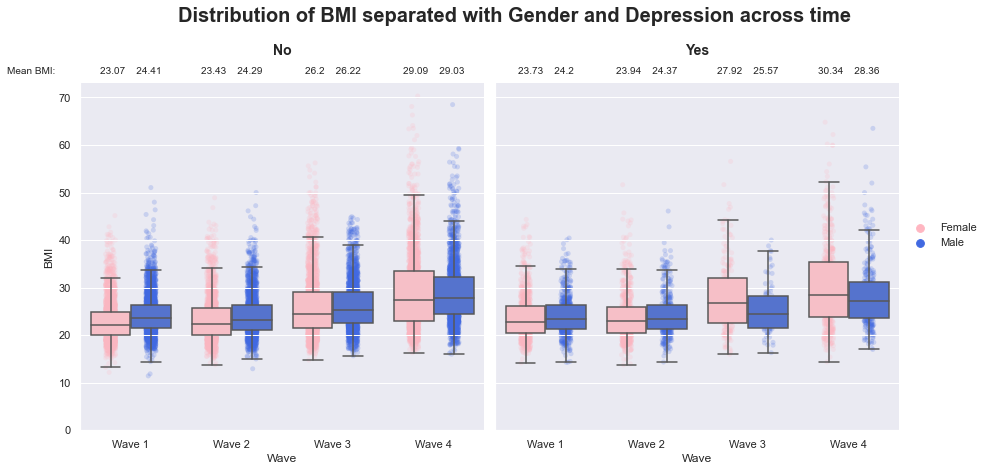

In [120]:
g = sns.FacetGrid(all_waves, col = "depression", height = 6)
gender_cols = {"F": "r", "M": "b"}

g.fig.suptitle('Distribution of BMI separated with Gender and Depression across time', y = 1.05, fontsize = 20, \
               fontweight = 'demi')

g.map_dataframe(sns.stripplot, x = "wave", y = "bmi", hue = "gender", jitter = True, \
                dodge = True, marker = 'o', alpha = 0.2, palette = sns.color_palette(('lightpink', 'royalblue')), \
                zorder = 0, hue_order = ['Female', 'Male'])
g.map_dataframe(sns.boxplot, x = "wave", y = "bmi", hue = "gender", palette =sns.color_palette(('lightpink', 'royalblue')), \
                showfliers = False, zorder = 1, hue_order = ['Female', 'Male'])

g.set_titles('{col_name}', pad = 28, size = 14, weight = 'demi')
g.set_axis_labels("Wave", "BMI")
g.set(ylim=(0, 73))
g.set_xticklabels(['Wave 1', 'Wave 2', 'Wave 3', 'Wave 4'])
g.add_legend(label_order = ['Female', 'Male'])

mean = all_waves.groupby(['depression','wave','gender'], as_index = False)['bmi'].mean().round(2)
mean = mean.groupby(['depression','wave'])['bmi'].apply(list)
means = []
for i in mean:
    means.append('    '.join(map(str, i)))

vertical_offset = 75
lst = list(np.arange(0,4,0.5))*2
count = 0
for ax in g.axes.flat:
    for i in ax.get_xticks():
        ax.text(i,vertical_offset, means[count], horizontalalignment = 'center')
        count += 1

plt.figtext(-0.04,0.895, 'Mean BMI:', horizontalalignment = 'left')
plt.show()

In [121]:
w2_variables = w2_variables.rename(columns = {'bmi_unadjusted_self_reported':'bmi_self_reported'})
w2_w4_bmi_diff = pd.concat([w2_variables[['bmi', 'bmi_self_reported', 'wave']], \
         w3_variables[['bmi', 'bmi_self_reported', 'wave']], \
         w4_variables[['bmi', 'bmi_self_reported', 'wave']]])

w2_w4_bmi_diff

,bmi,bmi_self_reported,wave
0,23.430985,23.430985,wave_2
1,21.967386,24.646528,wave_2
2,22.141184,19.577551,wave_2
3,31.098232,27.435055,wave_2
4,24.863526,21.256810,wave_2
...,...,...,...
5037,20.900000,19.529695,wave_4
5038,31.900000,2.902518,wave_4
5039,25.400000,25.090233,wave_4
5040,27.700000,27.922621,wave_4


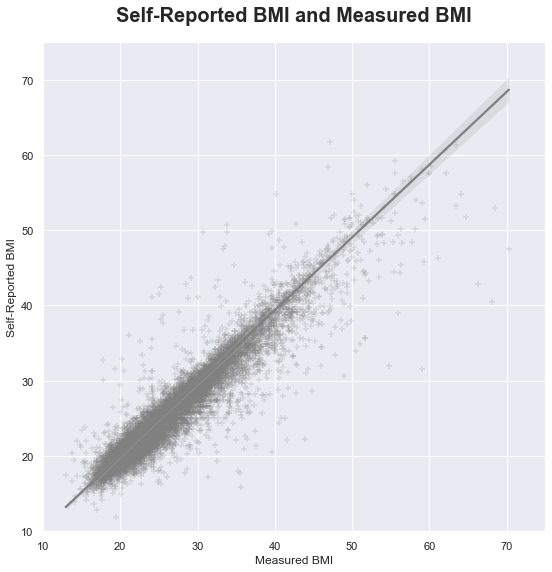

In [122]:
g, ax = plt.subplots()
g.set_size_inches(9, 9)

g = sns.regplot(data=w2_w4_bmi_diff, x="bmi", y = "bmi_self_reported", scatter_kws={'alpha' : 0.2}, marker = "+", \
               color = 'grey')
g.set_title('Self-Reported BMI and Measured BMI', y = 1.03, fontsize = 20, \
               fontweight = 'demi')
g.set(ylim=(10, 75), xlim=(10,75), xlabel = 'Measured BMI', ylabel = 'Self-Reported BMI')
plt.show()

Measured BMI is more than self-reported BMI.